In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 2
2023-07-23 01:13:41.560079


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-11.2071)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(5.7558)
penalty_target_min tensor(-12.3088) penalty_target_max tensor(0.3810)
train_loss:  -10.498390824127197
valid_loss:  -10.25041947631836
h_min_tilde -12.308785 ell_tilde -10.448796554565428 kappa_tilde 0.00073323776615612


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.6689300537109375e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 7.14080023765564

 2 6.899053335189819

 3 6.958895683288574

 4 6.83462119102478

 5 7.001012802124023

 6 6.972956418991089

 7 7.1545844078063965

 8 6.918365240097046

 9 6.772364139556885

 10 6.65278172492981

 11 6.752728223800659

 12 6.873170614242554

 13 6.582798004150391

 14 6.916617155075073

 15 6.733620643615723

 16 7.025599241256714

 17 4.231981515884399

 18 3.4193243980407715

 19 3.4787330627441406

 20 6.288835525512695

 21 3.3267757892608643

 22 3.250882863998413

 23 3.3001458644866943

 24 3.3500094413757324

 25 3.3865575790405273

 26 3.537079334259033

 27 2.9947478771209717

 28 3.2168068885803223

 29 3.455826759338379

 30 3.1532576084136963

 31 3.4239938259124756

 32 3.2827866077423096

 33 3.298044204711914

 34 3.4797885417938232

 35 3.537437915802002

 36 3.152724266052246

 37 3.4018163681030273

 38 3.248900890350342

 39 3.1943867206573486

 40 3.199174642562866

 41 3.4519107341766357

 42 3.234128952026367

 43 3.22857928276062

 44 3.3

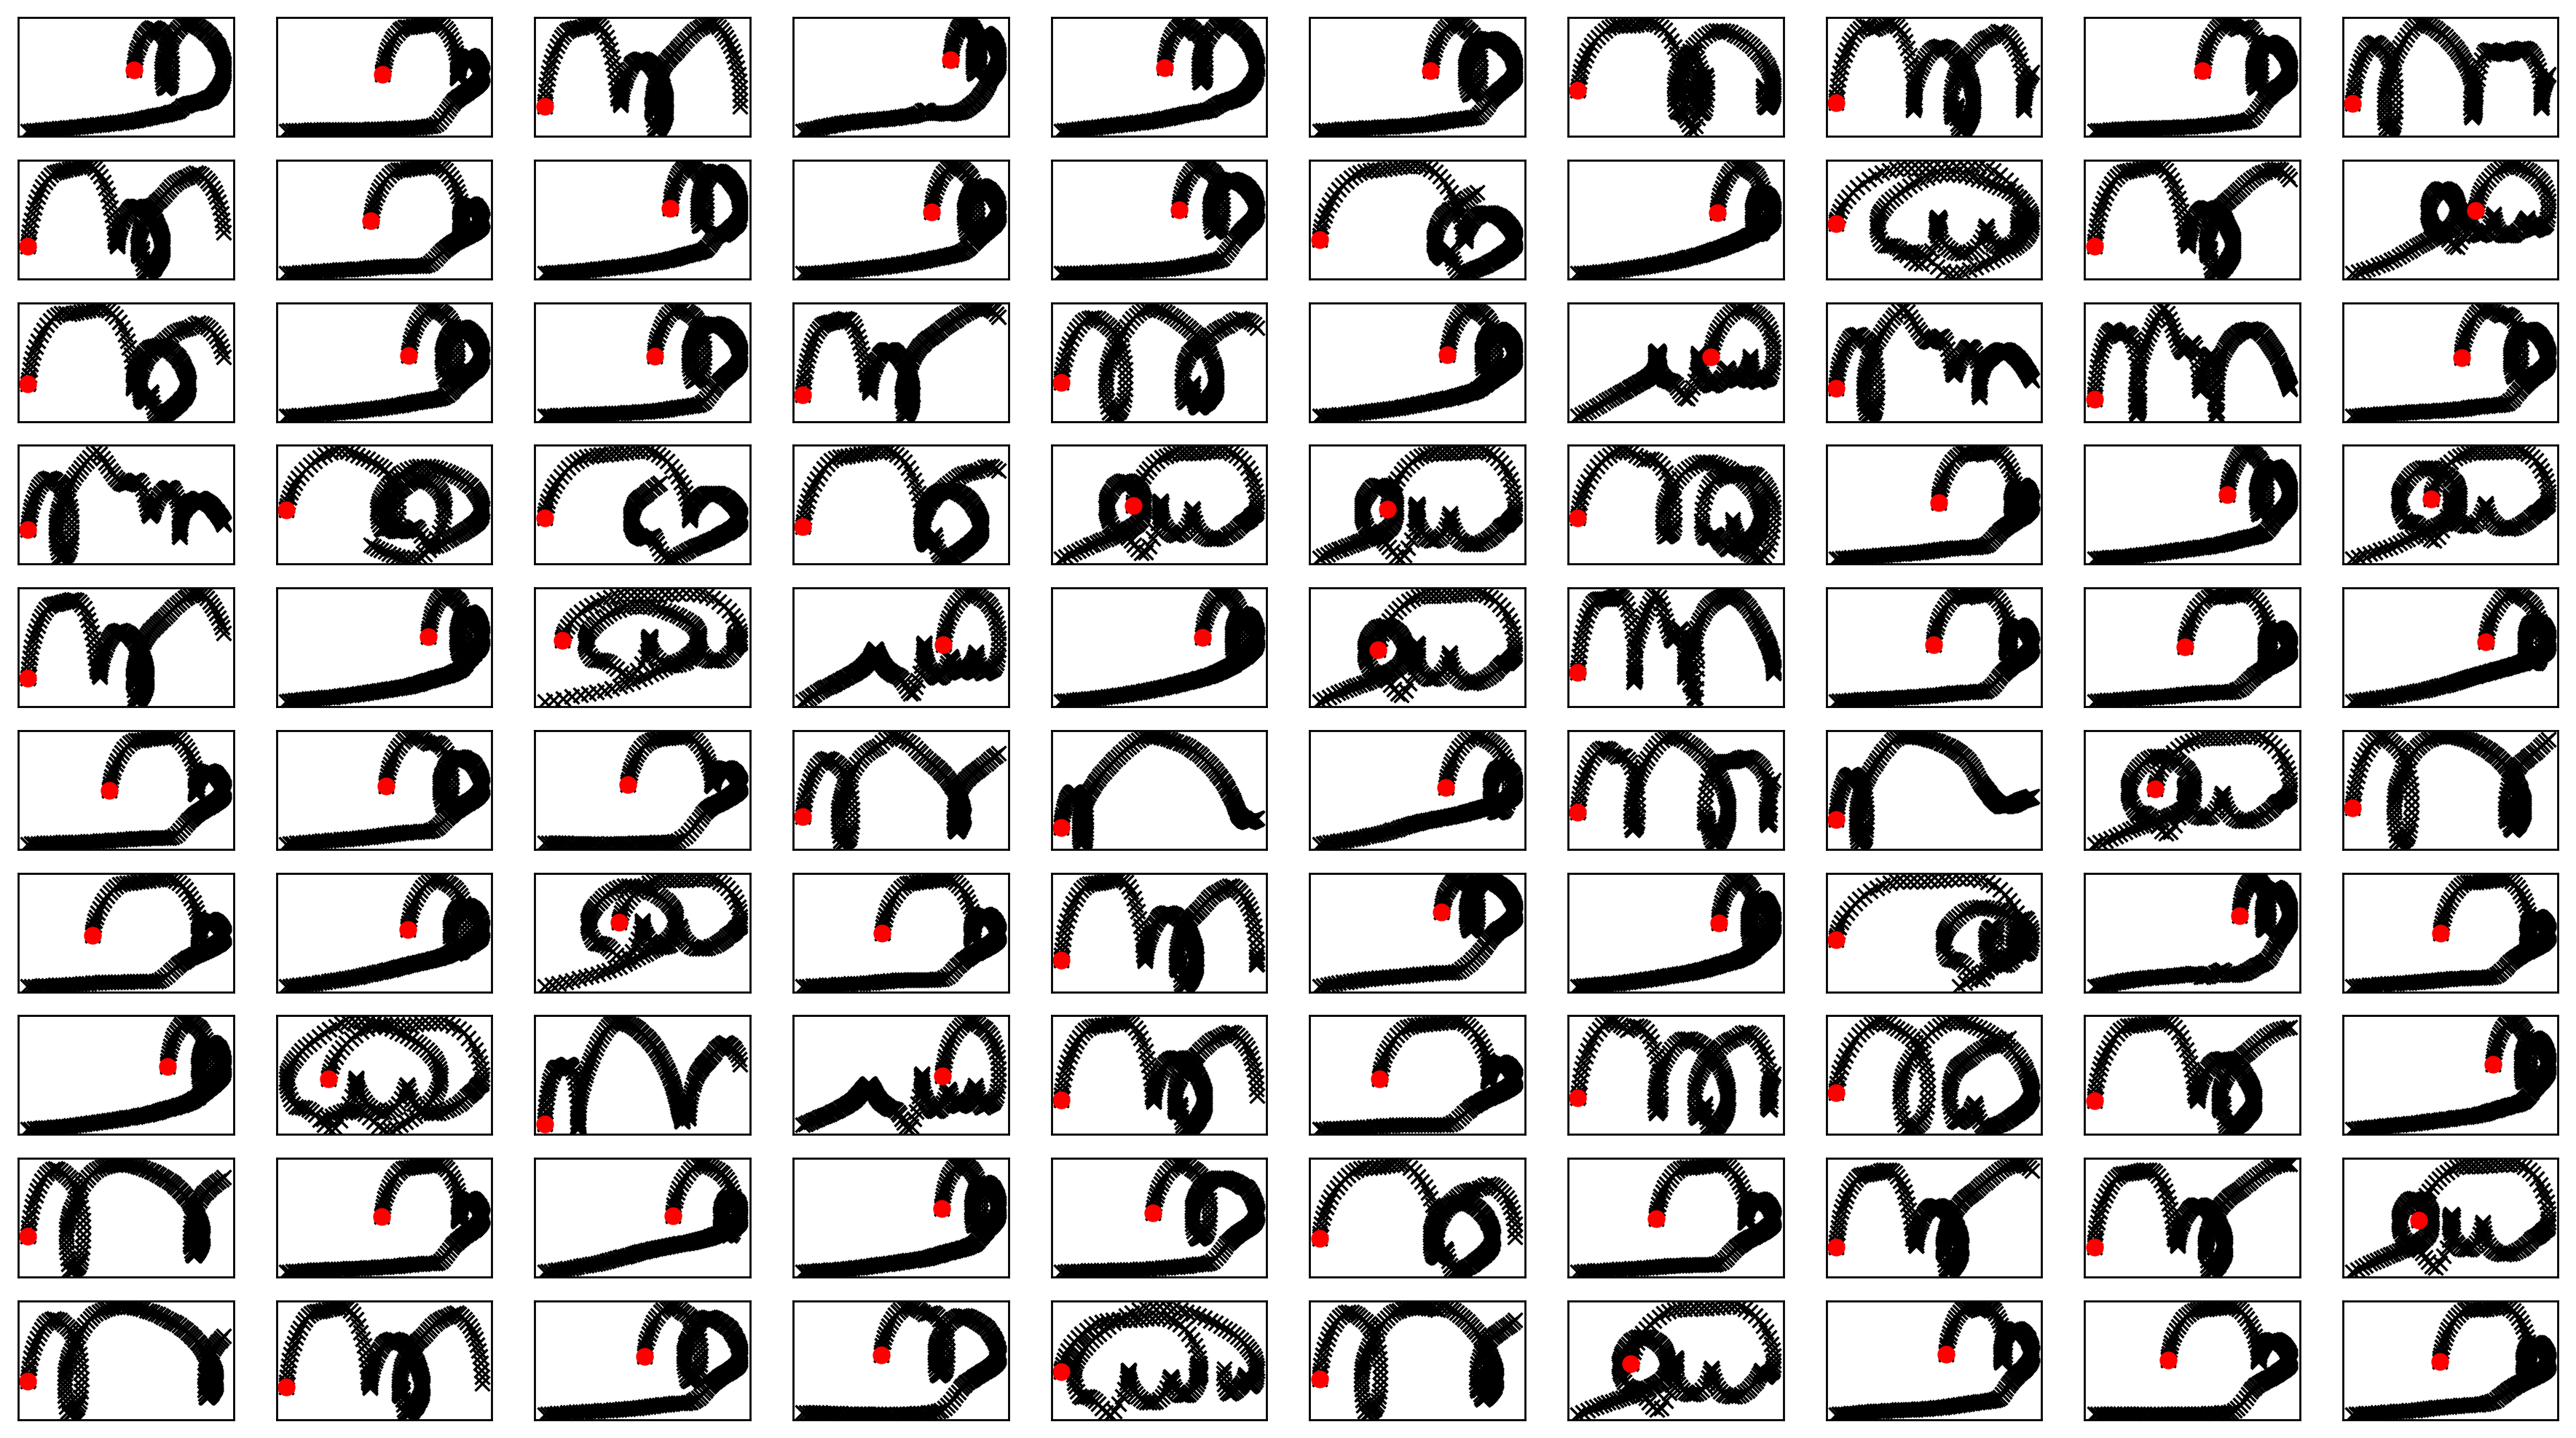

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

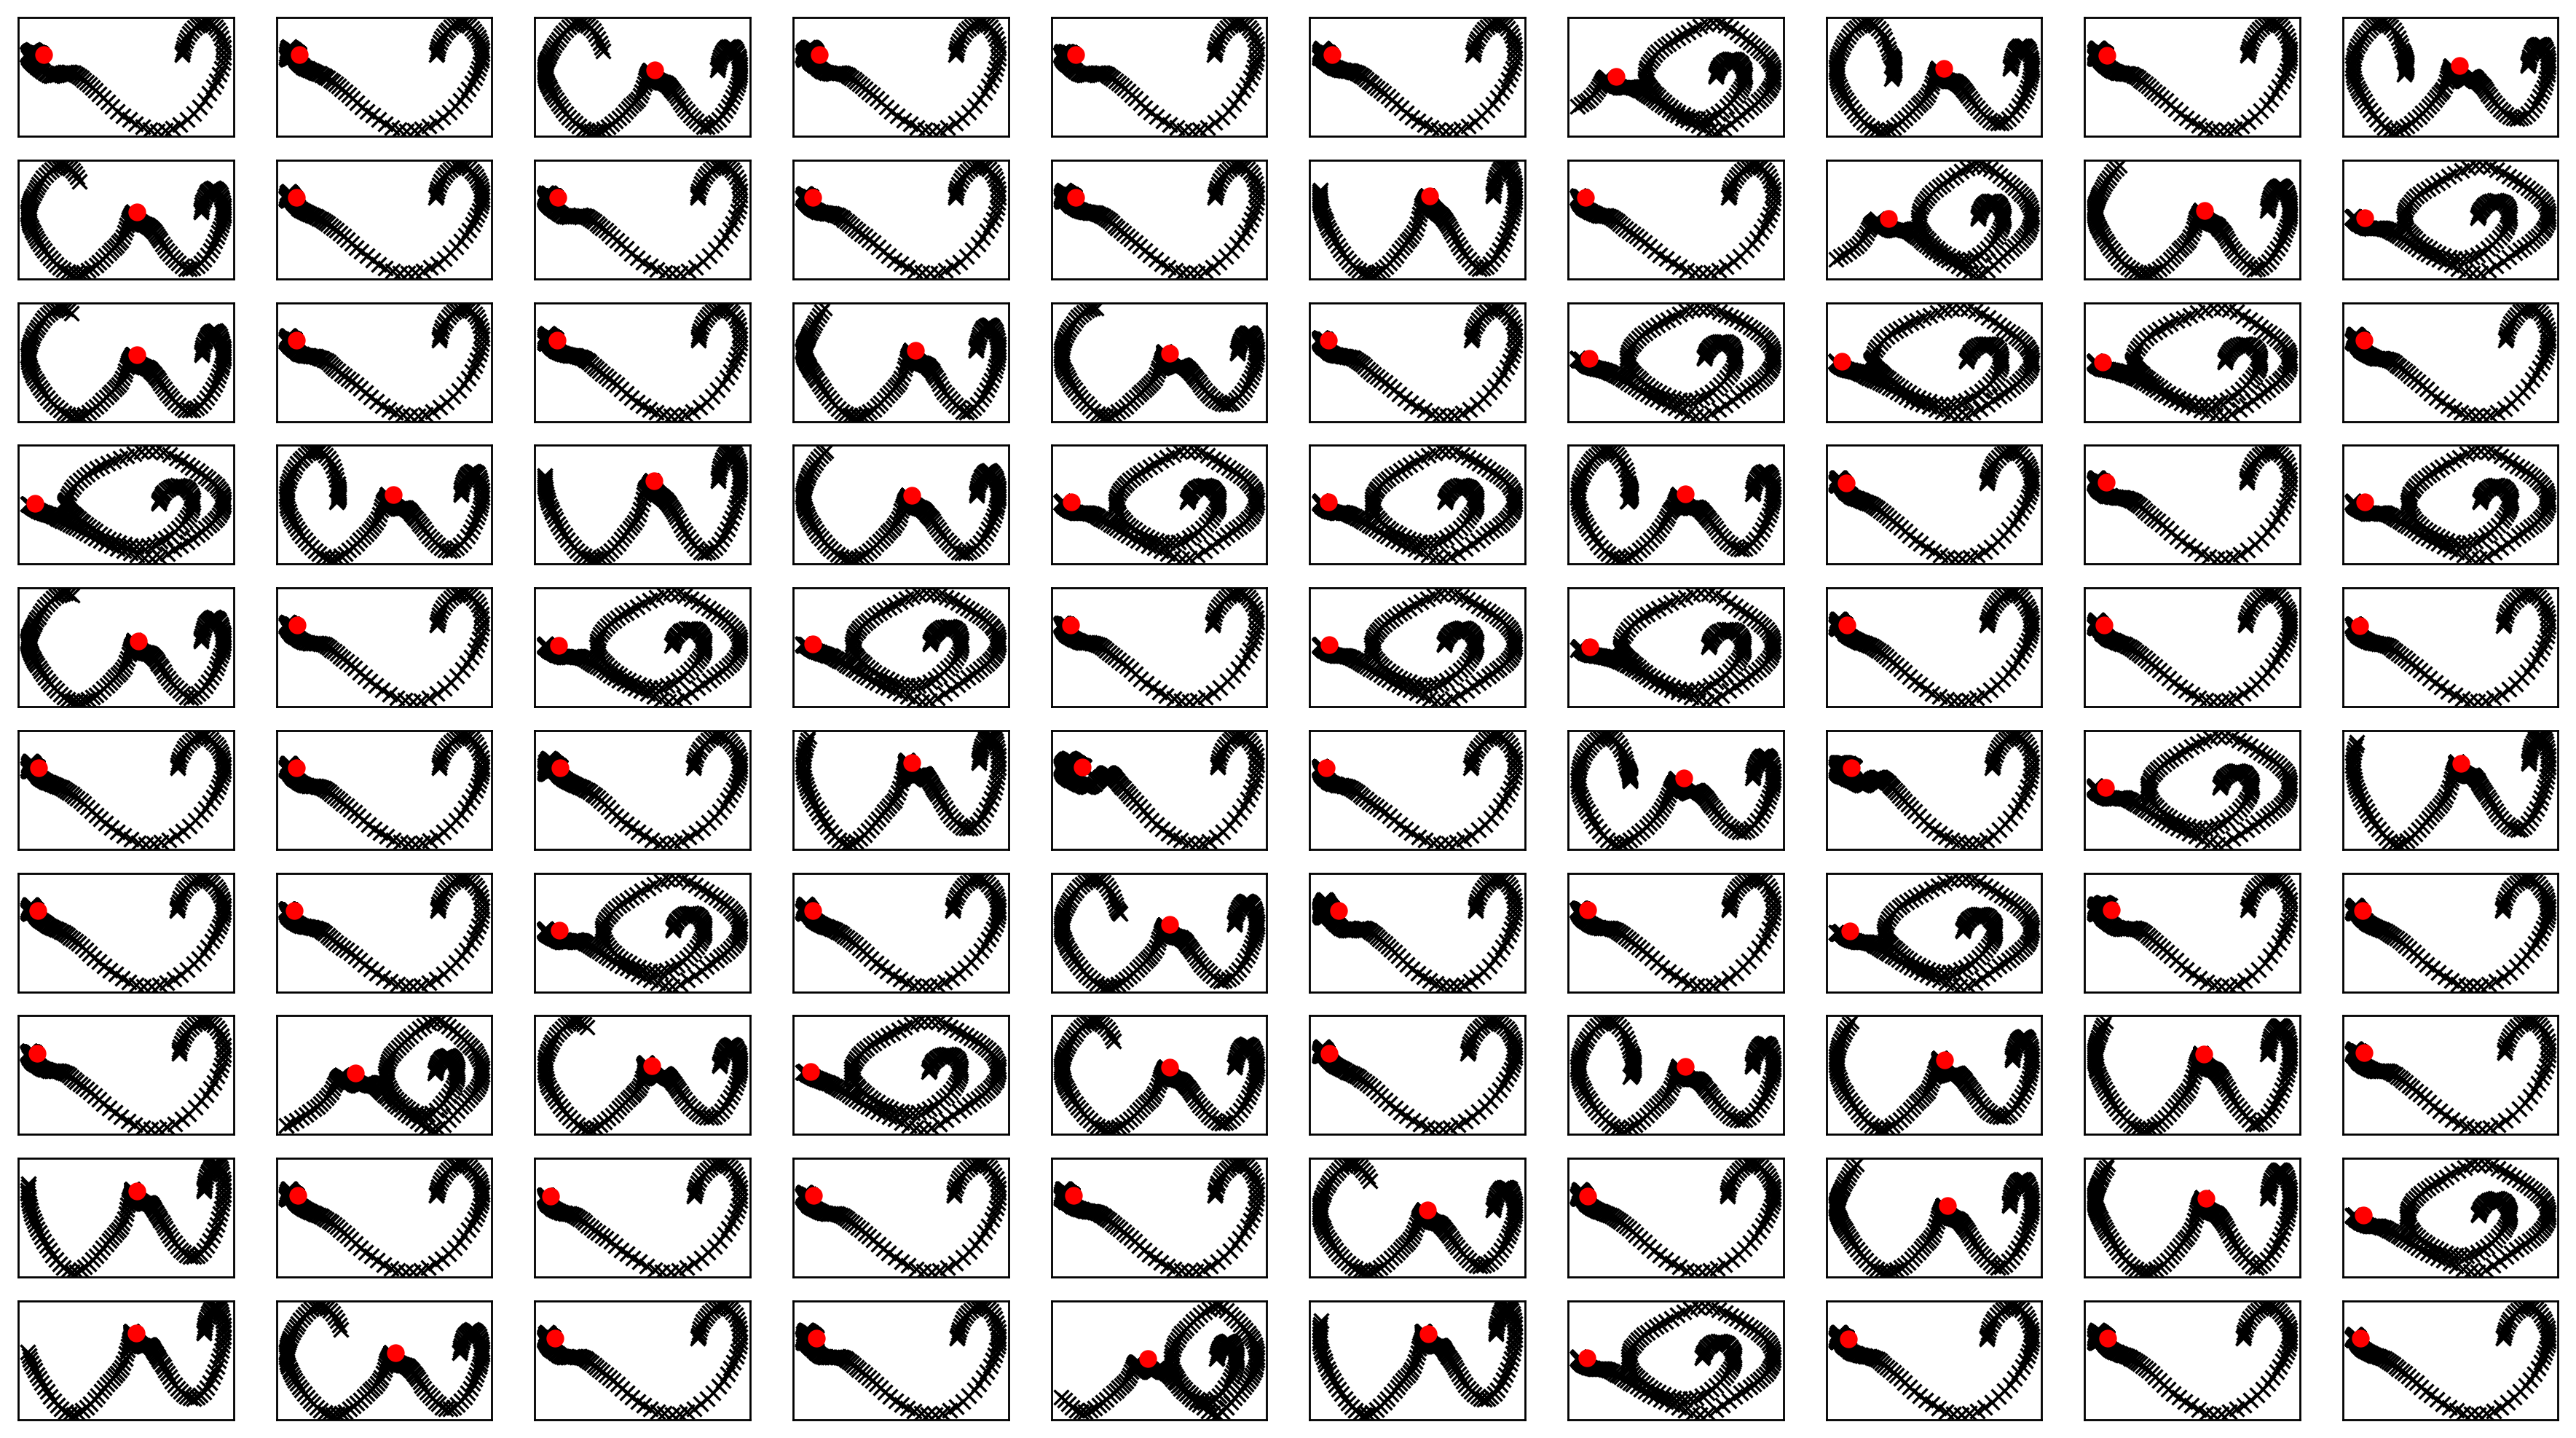

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-23 01:20:58.685208


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.37802  validloss 1.42248±0.00000  bestvalidloss 1.42248  last_update 0
train: iter 1  trainloss 1.30266  validloss 1.35296±0.00000  bestvalidloss 1.35296  last_update 0
train: iter 2  trainloss 1.23841  validloss 1.30297±0.00000  bestvalidloss 1.30297  last_update 0
train: iter 3  trainloss 1.20436  validloss 1.27182±0.00000  bestvalidloss 1.27182  last_update 0
train: iter 4  trainloss 1.17662  validloss 1.24427±0.00000  bestvalidloss 1.24427  last_update 0
train: iter 5  trainloss 1.14869  validloss 1.21842±0.00000  bestvalidloss 1.21842  last_update 0
train: iter 6  trainloss 1.12355  validloss 1.20076±0.00000  bestvalidloss 1.20076  last_update 0
train: iter 7  trainloss 1.09207  validloss 1.16458±0.00000  bestvalidloss 1.16458  last_update 0
train: iter 8  trainloss 1.06888  validloss 1.13338±0.00000  bestvalidloss 1.13338  last_update 0
train: iter 9  trainloss 1.03928  validloss 1.08987±0.00000  bestvalidloss 1.08987  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.68284  validloss 0.68499±0.00000  bestvalidloss 0.68032  last_update 5
train: iter 84  trainloss 0.68473  validloss 0.70172±0.00000  bestvalidloss 0.68032  last_update 6
train: iter 85  trainloss 0.68319  validloss 0.68579±0.00000  bestvalidloss 0.68032  last_update 7
train: iter 86  trainloss 0.68528  validloss 0.70310±0.00000  bestvalidloss 0.68032  last_update 8
train: iter 87  trainloss 0.68372  validloss 0.67790±0.00000  bestvalidloss 0.67790  last_update 0
train: iter 88  trainloss 0.67643  validloss 0.68090±0.00000  bestvalidloss 0.67790  last_update 1
train: iter 89  trainloss 0.68318  validloss 0.71572±0.00000  bestvalidloss 0.67790  last_update 2
train: iter 90  trainloss 0.68561  validloss 0.68493±0.00000  bestvalidloss 0.67790  last_update 3
train: iter 91  trainloss 0.68769  validloss 0.71059±0.00000  bestvalidloss 0.67790  last_update 4
train: iter 92  trainloss 0.68407  validloss 0.69075±0.00000  bestvalidloss 0.67790  last_update 5
train: ite

train: iter 165  trainloss 0.63792  validloss 0.65319±0.00000  bestvalidloss 0.63446  last_update 3
train: iter 166  trainloss 0.64049  validloss 0.64346±0.00000  bestvalidloss 0.63446  last_update 4
train: iter 167  trainloss 0.63769  validloss 0.66053±0.00000  bestvalidloss 0.63446  last_update 5
train: iter 168  trainloss 0.64382  validloss 0.64361±0.00000  bestvalidloss 0.63446  last_update 6
train: iter 169  trainloss 0.64473  validloss 0.65862±0.00000  bestvalidloss 0.63446  last_update 7
train: iter 170  trainloss 0.63499  validloss 0.67403±0.00000  bestvalidloss 0.63446  last_update 8
train: iter 171  trainloss 0.63775  validloss 0.67611±0.00000  bestvalidloss 0.63446  last_update 9
train: iter 172  trainloss 0.63408  validloss 0.64493±0.00000  bestvalidloss 0.63446  last_update 10
train: iter 173  trainloss 0.64482  validloss 0.69138±0.00000  bestvalidloss 0.63446  last_update 11
train: iter 174  trainloss 0.65016  validloss 0.66790±0.00000  bestvalidloss 0.63446  last_update 

train: iter 247  trainloss 0.61711  validloss 0.64468±0.00000  bestvalidloss 0.61929  last_update 7
train: iter 248  trainloss 0.61829  validloss 0.68524±0.00000  bestvalidloss 0.61929  last_update 8
train: iter 249  trainloss 0.61181  validloss 0.63603±0.00000  bestvalidloss 0.61929  last_update 9
train: iter 250  trainloss 0.61035  validloss 0.62997±0.00000  bestvalidloss 0.61929  last_update 10
train: iter 251  trainloss 0.61103  validloss 0.62988±0.00000  bestvalidloss 0.61929  last_update 11
train: iter 252  trainloss 0.61099  validloss 0.67250±0.00000  bestvalidloss 0.61929  last_update 12
train: iter 253  trainloss 0.61140  validloss 0.63588±0.00000  bestvalidloss 0.61929  last_update 13
train: iter 254  trainloss 0.61712  validloss 0.64537±0.00000  bestvalidloss 0.61929  last_update 14
train: iter 255  trainloss 0.61160  validloss 0.62089±0.00000  bestvalidloss 0.61929  last_update 15
train: iter 256  trainloss 0.61678  validloss 0.64733±0.00000  bestvalidloss 0.61929  last_upd

train: iter 329  trainloss 0.59509  validloss 0.63968±0.00000  bestvalidloss 0.60672  last_update 53
train: iter 330  trainloss 0.59791  validloss 0.62910±0.00000  bestvalidloss 0.60672  last_update 54
train: iter 331  trainloss 0.59095  validloss 0.62616±0.00000  bestvalidloss 0.60672  last_update 55
train: iter 332  trainloss 0.59030  validloss 0.63136±0.00000  bestvalidloss 0.60672  last_update 56
train: iter 333  trainloss 0.60629  validloss 0.61911±0.00000  bestvalidloss 0.60672  last_update 57
train: iter 334  trainloss 0.58823  validloss 0.61975±0.00000  bestvalidloss 0.60672  last_update 58
train: iter 335  trainloss 0.58766  validloss 0.62630±0.00000  bestvalidloss 0.60672  last_update 59
train: iter 336  trainloss 0.58980  validloss 0.62546±0.00000  bestvalidloss 0.60672  last_update 60
train: iter 337  trainloss 0.59650  validloss 0.61456±0.00000  bestvalidloss 0.60672  last_update 61
train: iter 338  trainloss 0.59821  validloss 0.64854±0.00000  bestvalidloss 0.60672  last_

train: iter 411  trainloss 0.57485  validloss 0.61945±0.00000  bestvalidloss 0.59499  last_update 14
train: iter 412  trainloss 0.58257  validloss 0.62630±0.00000  bestvalidloss 0.59499  last_update 15
train: iter 413  trainloss 0.58325  validloss 0.60604±0.00000  bestvalidloss 0.59499  last_update 16
train: iter 414  trainloss 0.57988  validloss 0.63115±0.00000  bestvalidloss 0.59499  last_update 17
train: iter 415  trainloss 0.57523  validloss 0.61000±0.00000  bestvalidloss 0.59499  last_update 18
train: iter 416  trainloss 0.57972  validloss 0.62867±0.00000  bestvalidloss 0.59499  last_update 19
train: iter 417  trainloss 0.58109  validloss 0.61034±0.00000  bestvalidloss 0.59499  last_update 20
train: iter 418  trainloss 0.57646  validloss 0.63542±0.00000  bestvalidloss 0.59499  last_update 21
train: iter 419  trainloss 0.58151  validloss 0.60670±0.00000  bestvalidloss 0.59499  last_update 22
train: iter 420  trainloss 0.57488  validloss 0.61577±0.00000  bestvalidloss 0.59499  last_

train: iter 493  trainloss 0.56975  validloss 0.60770±0.00000  bestvalidloss 0.59006  last_update 12
train: iter 494  trainloss 0.56244  validloss 0.60045±0.00000  bestvalidloss 0.59006  last_update 13
train: iter 495  trainloss 0.57305  validloss 0.61491±0.00000  bestvalidloss 0.59006  last_update 14
train: iter 496  trainloss 0.56529  validloss 0.59971±0.00000  bestvalidloss 0.59006  last_update 15
train: iter 497  trainloss 0.56534  validloss 0.60731±0.00000  bestvalidloss 0.59006  last_update 16
train: iter 498  trainloss 0.57029  validloss 0.61251±0.00000  bestvalidloss 0.59006  last_update 17
train: iter 499  trainloss 0.56756  validloss 0.60563±0.00000  bestvalidloss 0.59006  last_update 18
train: iter 500  trainloss 0.57024  validloss 0.61095±0.00000  bestvalidloss 0.59006  last_update 19
train: iter 501  trainloss 0.57117  validloss 0.59942±0.00000  bestvalidloss 0.59006  last_update 20
train: iter 502  trainloss 0.56676  validloss 0.59166±0.00000  bestvalidloss 0.59006  last_

train: iter 575  trainloss 0.56029  validloss 0.59072±0.00000  bestvalidloss 0.57611  last_update 59
train: iter 576  trainloss 0.55983  validloss 0.60532±0.00000  bestvalidloss 0.57611  last_update 60
train: iter 577  trainloss 0.55594  validloss 0.60669±0.00000  bestvalidloss 0.57611  last_update 61
train: iter 578  trainloss 0.56266  validloss 0.60523±0.00000  bestvalidloss 0.57611  last_update 62
train: iter 579  trainloss 0.55894  validloss 0.57835±0.00000  bestvalidloss 0.57611  last_update 63
train: iter 580  trainloss 0.55386  validloss 0.60031±0.00000  bestvalidloss 0.57611  last_update 64
train: iter 581  trainloss 0.55894  validloss 0.60390±0.00000  bestvalidloss 0.57611  last_update 65
train: iter 582  trainloss 0.55751  validloss 0.59879±0.00000  bestvalidloss 0.57611  last_update 66
train: iter 583  trainloss 0.55569  validloss 0.59502±0.00000  bestvalidloss 0.57611  last_update 67
train: iter 584  trainloss 0.55330  validloss 0.59386±0.00000  bestvalidloss 0.57611  last_

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -7.245233006525041
valid_loss:  -8.667775255966188
weight_alpha 1.0 h_min_tilde -12.308785 ell_tilde -7.52974145641327 kappa_tilde 0.0004574351003992089
train_loss:  -7.3085340454101555
valid_loss:  -7.072312886810304
weight_alpha 0.1 h_min_tilde -12.308785 ell_tilde -7.261289813690184 kappa_tilde 0.0004451045403796832


In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1439.48590  validloss -1417.78560±0.00000  bestvalidloss -1417.78560  last_update 0
train: iter 1  trainloss -1442.72574  validloss -1403.01078±0.00000  bestvalidloss -1417.78560  last_update 1
train: iter 2  trainloss -1446.45358  validloss -1410.14445±0.00000  bestvalidloss -1417.78560  last_update 2
train: iter 3  trainloss -1446.77237  validloss -1400.90829±0.00000  bestvalidloss -1417.78560  last_update 3
train: iter 4  trainloss -1433.58809  validloss -1402.06483±0.00000  bestvalidloss -1417.78560  last_update 4
train: iter 5  trainloss -1439.33348  validloss -1396.38750±0.00000  bestvalidloss -1417.78560  last_update 5
train: iter 6  trainloss -1449.67015  validloss -1384.48271±0.00000  bestvalidloss -1417.78560  last_update 6
train: iter 7  trainloss -1449.82039  validloss -1364.62973±0.00000  bestvalidloss -1417.78560  last_update 7
train: iter 8  trainloss -1453.88640  validloss -1362.90473±0.00000  bestva

train: iter 74  trainloss -1471.53199  validloss -1383.43915±0.00000  bestvalidloss -1455.06673  last_update 44
train: iter 75  trainloss -1480.21576  validloss -1412.43432±0.00000  bestvalidloss -1455.06673  last_update 45
train: iter 76  trainloss -1454.83441  validloss -1340.14203±0.00000  bestvalidloss -1455.06673  last_update 46
train: iter 77  trainloss -1477.34200  validloss -1415.15943±0.00000  bestvalidloss -1455.06673  last_update 47
train: iter 78  trainloss -1485.27737  validloss -1372.72950±0.00000  bestvalidloss -1455.06673  last_update 48
train: iter 79  trainloss -1418.30011  validloss -1389.56444±0.00000  bestvalidloss -1455.06673  last_update 49
train: iter 80  trainloss -1455.13724  validloss -1378.38887±0.00000  bestvalidloss -1455.06673  last_update 50
train: iter 81  trainloss -1479.91897  validloss -1388.27367±0.00000  bestvalidloss -1455.06673  last_update 51
train: iter 82  trainloss -1482.85447  validloss -1422.50398±0.00000  bestvalidloss -1455.06673  last_up

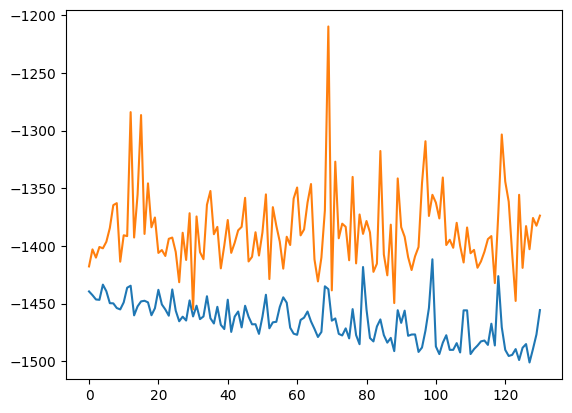

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-23 01:50:05.215818


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.70856  validloss 0.73881±0.00000  bestvalidloss 0.73881  last_update 0
train: iter 1  trainloss 0.67889  validloss 0.69091±0.00000  bestvalidloss 0.69091  last_update 0
train: iter 2  trainloss 0.68214  validloss 0.66964±0.00000  bestvalidloss 0.66964  last_update 0
train: iter 3  trainloss 0.66449  validloss 0.68589±0.00000  bestvalidloss 0.66964  last_update 1
train: iter 4  trainloss 0.66598  validloss 0.68518±0.00000  bestvalidloss 0.66964  last_update 2
train: iter 5  trainloss 0.66045  validloss 0.66725±0.00000  bestvalidloss 0.66725  last_update 0
train: iter 6  trainloss 0.65795  validloss 0.68427±0.00000  bestvalidloss 0.66725  last_update 1
train: iter 7  trainloss 0.65348  validloss 0.68237±0.00000  bestvalidloss 0.66725  last_update 2
train: iter 8  trainloss 0.65331  validloss 0.66768±0.00000  bestvalidloss 0.66725  last_update 3
train: iter 9  trainloss 0.65514  validloss 0.66157±0.00000  bestvalidloss 0.66157  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.62040  validloss 0.67973±0.00000  bestvalidloss 0.65668  last_update 72
train: iter 84  trainloss 0.62245  validloss 0.67588±0.00000  bestvalidloss 0.65668  last_update 73
train: iter 85  trainloss 0.61992  validloss 0.65633±0.00000  bestvalidloss 0.65633  last_update 0
train: iter 86  trainloss 0.61730  validloss 0.66964±0.00000  bestvalidloss 0.65633  last_update 1
train: iter 87  trainloss 0.62191  validloss 0.68129±0.00000  bestvalidloss 0.65633  last_update 2
train: iter 88  trainloss 0.62198  validloss 0.66954±0.00000  bestvalidloss 0.65633  last_update 3
train: iter 89  trainloss 0.62170  validloss 0.67967±0.00000  bestvalidloss 0.65633  last_update 4
train: iter 90  trainloss 0.61876  validloss 0.67337±0.00000  bestvalidloss 0.65633  last_update 5
train: iter 91  trainloss 0.61659  validloss 0.68898±0.00000  bestvalidloss 0.65633  last_update 6
train: iter 92  trainloss 0.61699  validloss 0.68214±0.00000  bestvalidloss 0.65633  last_update 7
train: i

train: iter 165  trainloss 0.60136  validloss 0.66676±0.00000  bestvalidloss 0.65334  last_update 10
train: iter 166  trainloss 0.60461  validloss 0.67121±0.00000  bestvalidloss 0.65334  last_update 11
train: iter 167  trainloss 0.60355  validloss 0.66466±0.00000  bestvalidloss 0.65334  last_update 12
train: iter 168  trainloss 0.60768  validloss 0.67923±0.00000  bestvalidloss 0.65334  last_update 13
train: iter 169  trainloss 0.60643  validloss 0.66666±0.00000  bestvalidloss 0.65334  last_update 14
train: iter 170  trainloss 0.60464  validloss 0.66129±0.00000  bestvalidloss 0.65334  last_update 15
train: iter 171  trainloss 0.60311  validloss 0.67624±0.00000  bestvalidloss 0.65334  last_update 16
train: iter 172  trainloss 0.60086  validloss 0.65668±0.00000  bestvalidloss 0.65334  last_update 17
train: iter 173  trainloss 0.60143  validloss 0.66092±0.00000  bestvalidloss 0.65334  last_update 18
train: iter 174  trainloss 0.59858  validloss 0.65709±0.00000  bestvalidloss 0.65334  last_

train: iter 247  trainloss 0.59760  validloss 0.65508±0.00000  bestvalidloss 0.64849  last_update 51
train: iter 248  trainloss 0.59107  validloss 0.66170±0.00000  bestvalidloss 0.64849  last_update 52
train: iter 249  trainloss 0.58804  validloss 0.65906±0.00000  bestvalidloss 0.64849  last_update 53
train: iter 250  trainloss 0.58611  validloss 0.65089±0.00000  bestvalidloss 0.64849  last_update 54
train: iter 251  trainloss 0.59344  validloss 0.65131±0.00000  bestvalidloss 0.64849  last_update 55
train: iter 252  trainloss 0.59031  validloss 0.65313±0.00000  bestvalidloss 0.64849  last_update 56
train: iter 253  trainloss 0.58668  validloss 0.65793±0.00000  bestvalidloss 0.64849  last_update 57
train: iter 254  trainloss 0.58788  validloss 0.65011±0.00000  bestvalidloss 0.64849  last_update 58
train: iter 255  trainloss 0.58883  validloss 0.66109±0.00000  bestvalidloss 0.64849  last_update 59
train: iter 256  trainloss 0.58721  validloss 0.64949±0.00000  bestvalidloss 0.64849  last_

train: iter 329  trainloss 0.58243  validloss 0.62994±0.00000  bestvalidloss 0.62620  last_update 19
train: iter 330  trainloss 0.58092  validloss 0.65973±0.00000  bestvalidloss 0.62620  last_update 20
train: iter 331  trainloss 0.57486  validloss 0.64341±0.00000  bestvalidloss 0.62620  last_update 21
train: iter 332  trainloss 0.58044  validloss 0.66099±0.00000  bestvalidloss 0.62620  last_update 22
train: iter 333  trainloss 0.57451  validloss 0.64677±0.00000  bestvalidloss 0.62620  last_update 23
train: iter 334  trainloss 0.57648  validloss 0.64717±0.00000  bestvalidloss 0.62620  last_update 24
train: iter 335  trainloss 0.57979  validloss 0.68371±0.00000  bestvalidloss 0.62620  last_update 25
train: iter 336  trainloss 0.57568  validloss 0.63840±0.00000  bestvalidloss 0.62620  last_update 26
train: iter 337  trainloss 0.57634  validloss 0.64264±0.00000  bestvalidloss 0.62620  last_update 27
train: iter 338  trainloss 0.57578  validloss 0.64195±0.00000  bestvalidloss 0.62620  last_

train: iter 411  trainloss 0.57053  validloss 0.63079±0.00000  bestvalidloss 0.62152  last_update 3
train: iter 412  trainloss 0.57072  validloss 0.62409±0.00000  bestvalidloss 0.62152  last_update 4
train: iter 413  trainloss 0.57328  validloss 0.64587±0.00000  bestvalidloss 0.62152  last_update 5
train: iter 414  trainloss 0.57006  validloss 0.63217±0.00000  bestvalidloss 0.62152  last_update 6
train: iter 415  trainloss 0.56457  validloss 0.64578±0.00000  bestvalidloss 0.62152  last_update 7
train: iter 416  trainloss 0.57027  validloss 0.62970±0.00000  bestvalidloss 0.62152  last_update 8
train: iter 417  trainloss 0.56542  validloss 0.64781±0.00000  bestvalidloss 0.62152  last_update 9
train: iter 418  trainloss 0.56619  validloss 0.64261±0.00000  bestvalidloss 0.62152  last_update 10
train: iter 419  trainloss 0.57287  validloss 0.64522±0.00000  bestvalidloss 0.62152  last_update 11
train: iter 420  trainloss 0.56576  validloss 0.64085±0.00000  bestvalidloss 0.62152  last_update 

train: iter 493  trainloss 0.55779  validloss 0.63196±0.00000  bestvalidloss 0.62151  last_update 13
train: iter 494  trainloss 0.56071  validloss 0.63422±0.00000  bestvalidloss 0.62151  last_update 14
train: iter 495  trainloss 0.56047  validloss 0.63581±0.00000  bestvalidloss 0.62151  last_update 15
train: iter 496  trainloss 0.55925  validloss 0.63244±0.00000  bestvalidloss 0.62151  last_update 16
train: iter 497  trainloss 0.56089  validloss 0.68199±0.00000  bestvalidloss 0.62151  last_update 17
train: iter 498  trainloss 0.56363  validloss 0.65566±0.00000  bestvalidloss 0.62151  last_update 18
train: iter 499  trainloss 0.55824  validloss 0.63367±0.00000  bestvalidloss 0.62151  last_update 19
train: iter 500  trainloss 0.55903  validloss 0.64147±0.00000  bestvalidloss 0.62151  last_update 20
train: iter 501  trainloss 0.55735  validloss 0.63467±0.00000  bestvalidloss 0.62151  last_update 21
train: iter 502  trainloss 0.55581  validloss 0.63890±0.00000  bestvalidloss 0.62151  last_

train: iter 575  trainloss 0.54944  validloss 0.63402±0.00000  bestvalidloss 0.61787  last_update 63
train: iter 576  trainloss 0.55255  validloss 0.64607±0.00000  bestvalidloss 0.61787  last_update 64
train: iter 577  trainloss 0.55500  validloss 0.64924±0.00000  bestvalidloss 0.61787  last_update 65
train: iter 578  trainloss 0.55453  validloss 0.63743±0.00000  bestvalidloss 0.61787  last_update 66
train: iter 579  trainloss 0.55162  validloss 0.62771±0.00000  bestvalidloss 0.61787  last_update 67
train: iter 580  trainloss 0.55781  validloss 0.64138±0.00000  bestvalidloss 0.61787  last_update 68
train: iter 581  trainloss 0.55186  validloss 0.63445±0.00000  bestvalidloss 0.61787  last_update 69
train: iter 582  trainloss 0.55339  validloss 0.62551±0.00000  bestvalidloss 0.61787  last_update 70
train: iter 583  trainloss 0.55143  validloss 0.64438±0.00000  bestvalidloss 0.61787  last_update 71
train: iter 584  trainloss 0.55123  validloss 0.64523±0.00000  bestvalidloss 0.61787  last_

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.383405392247438
valid_loss:  -8.991053703689577
weight_alpha 1.0 h_min_tilde -12.186493 ell_tilde -6.904935054535866 kappa_tilde 0.0004351299520202747
train_loss:  -6.710878992843628
valid_loss:  -6.717687400054932
weight_alpha 0.1 h_min_tilde -12.186493 ell_tilde -6.712240674285889 kappa_tilde 0.00042740303069528374


In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1326.10986  validloss -1338.95552±0.00000  bestvalidloss -1338.95552  last_update 0
train: iter 1  trainloss -1332.91605  validloss -1325.11539±0.00000  bestvalidloss -1338.95552  last_update 1
train: iter 2  trainloss -1326.38790  validloss -1291.21919±0.00000  bestvalidloss -1338.95552  last_update 2
train: iter 3  trainloss -1340.06551  validloss -1307.90734±0.00000  bestvalidloss -1338.95552  last_update 3
train: iter 4  trainloss -1339.63969  validloss -1314.63145±0.00000  bestvalidloss -1338.95552  last_update 4
train: iter 5  trainloss -1339.03186  validloss -1326.92474±0.00000  bestvalidloss -1338.95552  last_update 5
train: iter 6  trainloss -1327.97495  validloss -1305.59146±0.00000  bestvalidloss -1338.95552  last_update 6
train: iter 7  trainloss -1332.24611  validloss -1316.44110±0.00000  bestvalidloss -1338.95552  last_update 7
train: iter 8  trainloss -1322.04219  validloss -1311.32707±0.00000  bestva

train: iter 74  trainloss -1360.93280  validloss -1291.67779±0.00000  bestvalidloss -1350.25241  last_update 7
train: iter 75  trainloss -1356.16423  validloss -1310.75768±0.00000  bestvalidloss -1350.25241  last_update 8
train: iter 76  trainloss -1354.26931  validloss -1316.00369±0.00000  bestvalidloss -1350.25241  last_update 9
train: iter 77  trainloss -1350.26470  validloss -1293.49458±0.00000  bestvalidloss -1350.25241  last_update 10
train: iter 78  trainloss -1357.06758  validloss -1315.95899±0.00000  bestvalidloss -1350.25241  last_update 11
train: iter 79  trainloss -1363.82154  validloss -1298.96401±0.00000  bestvalidloss -1350.25241  last_update 12
train: iter 80  trainloss -1346.32199  validloss -1276.32959±0.00000  bestvalidloss -1350.25241  last_update 13
train: iter 81  trainloss -1355.85494  validloss -1317.84843±0.00000  bestvalidloss -1350.25241  last_update 14
train: iter 82  trainloss -1346.76871  validloss -1315.23929±0.00000  bestvalidloss -1350.25241  last_updat

train: iter 147  trainloss -1344.49357  validloss -1298.73525±0.00000  bestvalidloss -1358.23417  last_update 27
train: iter 148  trainloss -1370.71906  validloss -1304.31207±0.00000  bestvalidloss -1358.23417  last_update 28
train: iter 149  trainloss -1360.00928  validloss -1310.51558±0.00000  bestvalidloss -1358.23417  last_update 29
train: iter 150  trainloss -1373.94221  validloss -1355.05880±0.00000  bestvalidloss -1358.23417  last_update 30
train: iter 151  trainloss -1379.06904  validloss -1365.02757±0.00000  bestvalidloss -1365.02757  last_update 0
train: iter 152  trainloss -1374.48668  validloss -1321.00703±0.00000  bestvalidloss -1365.02757  last_update 1
train: iter 153  trainloss -1364.90814  validloss -1321.56927±0.00000  bestvalidloss -1365.02757  last_update 2
train: iter 154  trainloss -1379.40571  validloss -1306.21903±0.00000  bestvalidloss -1365.02757  last_update 3
train: iter 155  trainloss -1375.17568  validloss -1317.54521±0.00000  bestvalidloss -1365.02757  la

train: iter 220  trainloss -1386.16248  validloss -1366.57361±0.00000  bestvalidloss -1366.75834  last_update 11
train: iter 221  trainloss -1391.22757  validloss -1347.31083±0.00000  bestvalidloss -1366.75834  last_update 12
train: iter 222  trainloss -1395.80934  validloss -1360.48065±0.00000  bestvalidloss -1366.75834  last_update 13
train: iter 223  trainloss -1391.34717  validloss -1376.02816±0.00000  bestvalidloss -1376.02816  last_update 0
train: iter 224  trainloss -1391.69353  validloss -1374.76986±0.00000  bestvalidloss -1376.02816  last_update 1
train: iter 225  trainloss -1391.44228  validloss -1336.34681±0.00000  bestvalidloss -1376.02816  last_update 2
train: iter 226  trainloss -1383.24539  validloss -1349.39279±0.00000  bestvalidloss -1376.02816  last_update 3
train: iter 227  trainloss -1379.18461  validloss -1345.42057±0.00000  bestvalidloss -1376.02816  last_update 4
train: iter 228  trainloss -1367.81011  validloss -1329.25845±0.00000  bestvalidloss -1376.02816  las

train: iter 293  trainloss -1382.88540  validloss -1362.26547±0.00000  bestvalidloss -1390.85313  last_update 4
train: iter 294  trainloss -1397.89988  validloss -1352.67095±0.00000  bestvalidloss -1390.85313  last_update 5
train: iter 295  trainloss -1403.88484  validloss -1378.24663±0.00000  bestvalidloss -1390.85313  last_update 6
train: iter 296  trainloss -1407.99318  validloss -1346.46801±0.00000  bestvalidloss -1390.85313  last_update 7
train: iter 297  trainloss -1404.33321  validloss -1387.40157±0.00000  bestvalidloss -1390.85313  last_update 8
train: iter 298  trainloss -1359.41514  validloss -1318.07541±0.00000  bestvalidloss -1390.85313  last_update 9
train: iter 299  trainloss -1369.99836  validloss -1315.67558±0.00000  bestvalidloss -1390.85313  last_update 10
train: iter 300  trainloss -1394.87915  validloss -1327.89237±0.00000  bestvalidloss -1390.85313  last_update 11
train: iter 301  trainloss -1408.44730  validloss -1365.03888±0.00000  bestvalidloss -1390.85313  last

train: iter 366  trainloss -1411.93100  validloss -1338.51751±0.00000  bestvalidloss -1393.68488  last_update 2
train: iter 367  trainloss -1401.02534  validloss -1310.59053±0.00000  bestvalidloss -1393.68488  last_update 3
train: iter 368  trainloss -1401.67279  validloss -1374.07911±0.00000  bestvalidloss -1393.68488  last_update 4
train: iter 369  trainloss -1408.98615  validloss -1315.94149±0.00000  bestvalidloss -1393.68488  last_update 5
train: iter 370  trainloss -1415.72458  validloss -1328.54623±0.00000  bestvalidloss -1393.68488  last_update 6
train: iter 371  trainloss -1399.57316  validloss -1345.85735±0.00000  bestvalidloss -1393.68488  last_update 7
train: iter 372  trainloss -1413.89297  validloss -1385.61850±0.00000  bestvalidloss -1393.68488  last_update 8
train: iter 373  trainloss -1416.46233  validloss -1330.74924±0.00000  bestvalidloss -1393.68488  last_update 9
train: iter 374  trainloss -1410.12584  validloss -1338.67913±0.00000  bestvalidloss -1393.68488  last_u

train: iter 439  trainloss -1418.46686  validloss -1369.61365±0.00000  bestvalidloss -1407.92468  last_update 42
train: iter 440  trainloss -1415.14419  validloss -1357.80166±0.00000  bestvalidloss -1407.92468  last_update 43
train: iter 441  trainloss -1426.60644  validloss -1368.90781±0.00000  bestvalidloss -1407.92468  last_update 44
train: iter 442  trainloss -1419.37600  validloss -1372.40990±0.00000  bestvalidloss -1407.92468  last_update 45
train: iter 443  trainloss -1415.45344  validloss -1248.72871±0.00000  bestvalidloss -1407.92468  last_update 46
train: iter 444  trainloss -1363.57890  validloss -1377.59759±0.00000  bestvalidloss -1407.92468  last_update 47
train: iter 445  trainloss -1424.08340  validloss -1366.44223±0.00000  bestvalidloss -1407.92468  last_update 48
train: iter 446  trainloss -1439.14776  validloss -1381.85591±0.00000  bestvalidloss -1407.92468  last_update 49
train: iter 447  trainloss -1424.97155  validloss -1366.65401±0.00000  bestvalidloss -1407.92468

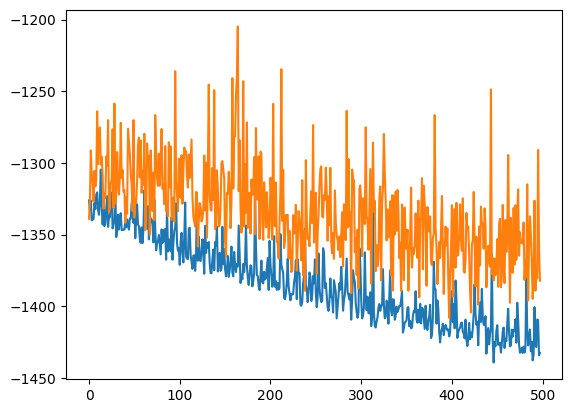

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-23 02:13:28.319197


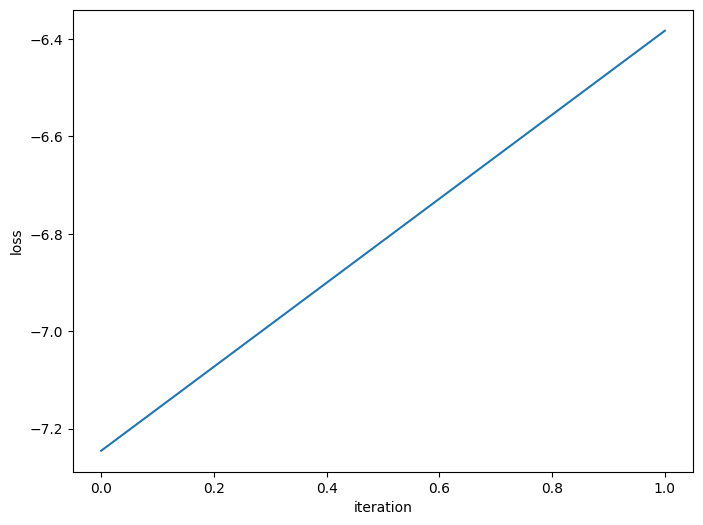

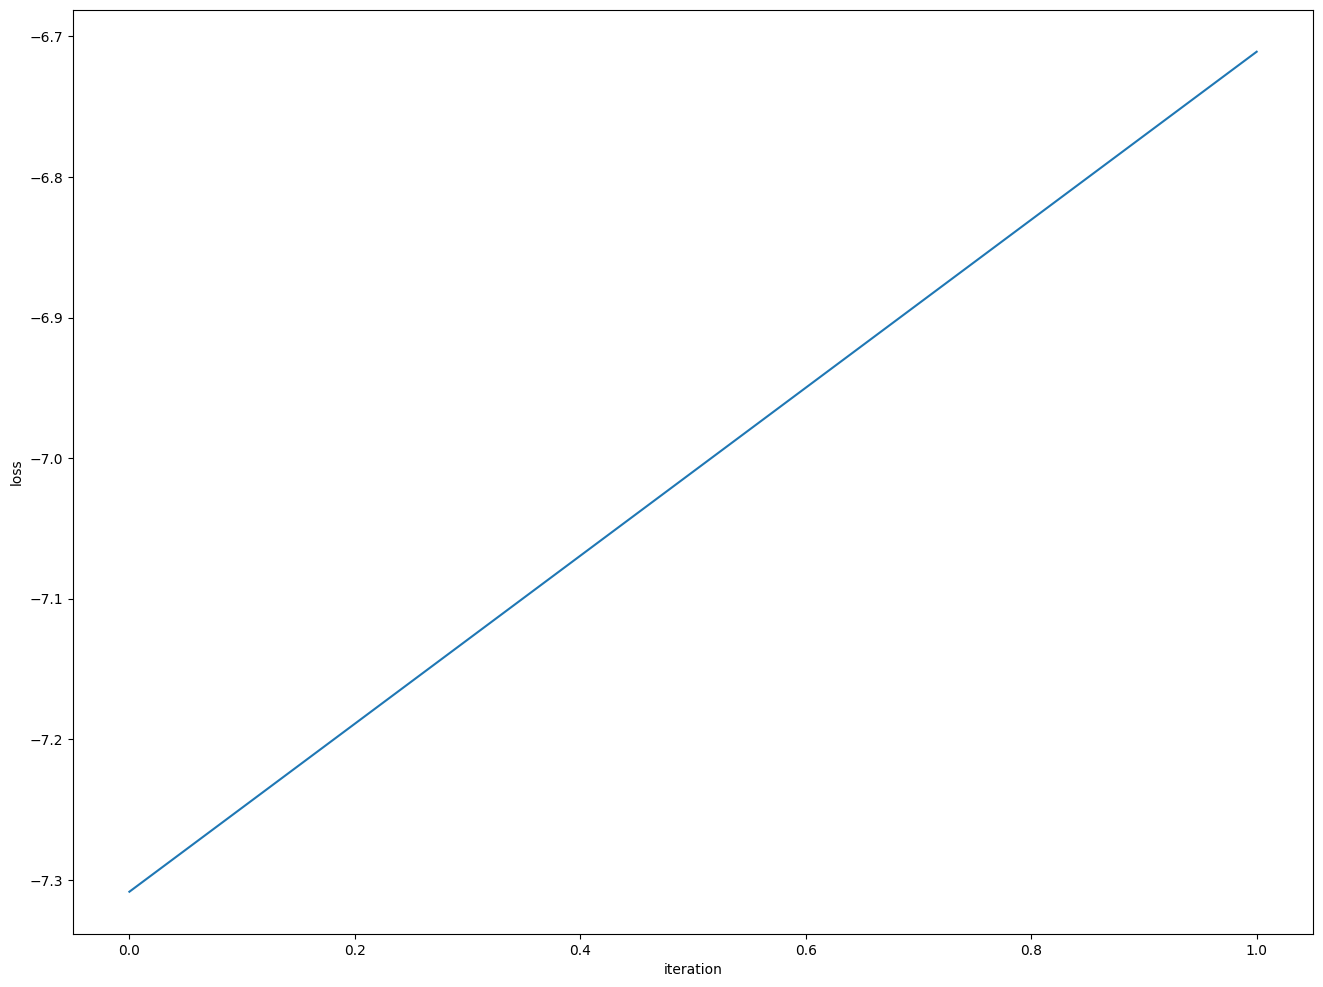

In [25]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(16,12))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [26]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [27]:
policy_evaluation_iter=2

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0
predict diverge [ -5.26660892 -10.09277408  -0.45617226  -1.04004649] [-0.19136937 -0.3978741  -0.03745665 -0.01469107] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 131

 1

 2
predict diverge [ -3.86277953 -10.32052136  -1.01631885  -3.05882106] [-0.20900608 -0.37215373 -0.12083473 -0.62162288] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 64
predict diverge [ -4.79131038 -10.16377375  -0.66291795  -1.61993097] [-0.22368544 -0.40506182 -0.05245037 -0.19721071] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 111

 3
predict diverge [  1.30652494   1.21729556 -15.06971745 -26.54585146] [ 0.02367126 -0.25706305 -0.41653681 -6.68462085] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 161

 4

 5

 6

 7

 8
predict diverge [ -5.21205855 -10.24174348  -0.6463949   -1.59119


 72

 73

 74

 75

 76

 77

 78

 79

 80
predict diverge [ -6.9145495  -10.28912961  -0.42334221  -0.3658872 ] [-0.21265893 -0.39729012 -0.01366697 -0.03110296] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 110

 81
predict diverge [-8.33301073 -9.99692218 -0.44658651  0.25273383] [-0.19169784 -0.35268567 -0.05917045  0.04506347] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 173

 82

 83
predict diverge [ -5.25790387 -10.02632327  -0.92155888  -4.01031305] [-0.20008173 -0.25295341 -0.10822119 -0.70295674] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 81

 84

 85

 86

 87

 88
predict diverge [-8.02944690e+00 -1.01029013e+01 -3.56272997e-01  3.17164386e-03] [-0.16464289 -0.32919815 -0.06416661 -0.01961755] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 103

 89

 9

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.78778  validloss 0.85090±0.00000  bestvalidloss 0.85090  last_update 0
train: iter 1  trainloss 0.73045  validloss 0.73763±0.00000  bestvalidloss 0.73763  last_update 0
train: iter 2  trainloss 0.70113  validloss 0.74273±0.00000  bestvalidloss 0.73763  last_update 1
train: iter 3  trainloss 0.68303  validloss 0.70986±0.00000  bestvalidloss 0.70986  last_update 0
train: iter 4  trainloss 0.67685  validloss 0.73029±0.00000  bestvalidloss 0.70986  last_update 1
train: iter 5  trainloss 0.67169  validloss 0.71102±0.00000  bestvalidloss 0.70986  last_update 2
train: iter 6  trainloss 0.66340  validloss 0.71055±0.00000  bestvalidloss 0.70986  last_update 3
train: iter 7  trainloss 0.65674  validloss 0.71032±0.00000  bestvalidloss 0.70986  last_update 4
train: iter 8  trainloss 0.65260  validloss 0.68876±0.00000  bestvalidloss 0.68876  last_update 0
train: iter 9  trainloss 0.64982  validloss 0.69915±0.00000  bestvalidloss 0.68876  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.59549  validloss 0.68141±0.00000  bestvalidloss 0.64967  last_update 7
train: iter 84  trainloss 0.59253  validloss 0.66117±0.00000  bestvalidloss 0.64967  last_update 8
train: iter 85  trainloss 0.59108  validloss 0.67555±0.00000  bestvalidloss 0.64967  last_update 9
train: iter 86  trainloss 0.59976  validloss 0.67680±0.00000  bestvalidloss 0.64967  last_update 10
train: iter 87  trainloss 0.59076  validloss 0.65488±0.00000  bestvalidloss 0.64967  last_update 11
train: iter 88  trainloss 0.59080  validloss 0.67153±0.00000  bestvalidloss 0.64967  last_update 12
train: iter 89  trainloss 0.59152  validloss 0.66068±0.00000  bestvalidloss 0.64967  last_update 13
train: iter 90  trainloss 0.59348  validloss 0.66400±0.00000  bestvalidloss 0.64967  last_update 14
train: iter 91  trainloss 0.59094  validloss 0.65166±0.00000  bestvalidloss 0.64967  last_update 15
train: iter 92  trainloss 0.59143  validloss 0.65787±0.00000  bestvalidloss 0.64967  last_update 16
tra

train: iter 166  trainloss 0.57218  validloss 0.66008±0.00000  bestvalidloss 0.64817  last_update 17
train: iter 167  trainloss 0.58149  validloss 0.67004±0.00000  bestvalidloss 0.64817  last_update 18
train: iter 168  trainloss 0.57600  validloss 0.67310±0.00000  bestvalidloss 0.64817  last_update 19
train: iter 169  trainloss 0.57199  validloss 0.65469±0.00000  bestvalidloss 0.64817  last_update 20
train: iter 170  trainloss 0.57286  validloss 0.65393±0.00000  bestvalidloss 0.64817  last_update 21
train: iter 171  trainloss 0.57884  validloss 0.67656±0.00000  bestvalidloss 0.64817  last_update 22
train: iter 172  trainloss 0.57054  validloss 0.66343±0.00000  bestvalidloss 0.64817  last_update 23
train: iter 173  trainloss 0.57199  validloss 0.65688±0.00000  bestvalidloss 0.64817  last_update 24
train: iter 174  trainloss 0.57070  validloss 0.67769±0.00000  bestvalidloss 0.64817  last_update 25
train: iter 175  trainloss 0.56994  validloss 0.67956±0.00000  bestvalidloss 0.64817  last_

train: iter 248  trainloss 0.56228  validloss 0.67165±0.00000  bestvalidloss 0.64817  last_update 99
train: iter 249  trainloss 0.56226  validloss 0.67726±0.00000  bestvalidloss 0.64817  last_update 100
train: fin


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.162715865758061
valid_loss:  -9.209225503921507
weight_alpha 1.0 h_min_tilde -12.32162 ell_tilde -6.77201779339075 kappa_tilde 0.0004244915733365377
train_loss:  -6.742852227020265
valid_loss:  -6.710789331817627
weight_alpha 0.1 h_min_tilde -12.32162 ell_tilde -6.736439647979737 kappa_tilde 0.00042313738688150337


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1339.63817  validloss -1344.00906±0.00000  bestvalidloss -1344.00906  last_update 0
train: iter 1  trainloss -1354.45742  validloss -1349.74353±0.00000  bestvalidloss -1349.74353  last_update 0
train: iter 2  trainloss -1356.93468  validloss -1363.62569±0.00000  bestvalidloss -1363.62569  last_update 0
train: iter 3  trainloss -1354.59010  validloss -1354.21104±0.00000  bestvalidloss -1363.62569  last_update 1
train: iter 4  trainloss -1361.12807  validloss -1343.61772±0.00000  bestvalidloss -1363.62569  last_update 2
train: iter 5  trainloss -1344.42814  validloss -1302.16621±0.00000  bestvalidloss -1363.62569  last_update 3
train: iter 6  trainloss -1334.53506  validloss -1331.10111±0.00000  bestvalidloss -1363.62569  last_update 4
train: iter 7  trainloss -1352.56763  validloss -1339.45259±0.00000  bestvalidloss -1363.62569  last_update 5
train: iter 8  trainloss -1349.15624  validloss -1359.49824±0.00000  bestva

train: iter 74  trainloss -1346.02482  validloss -1360.73851±0.00000  bestvalidloss -1405.49455  last_update 64
train: iter 75  trainloss -1332.57366  validloss -1207.14082±0.00000  bestvalidloss -1405.49455  last_update 65
train: iter 76  trainloss -1347.94806  validloss -1262.87978±0.00000  bestvalidloss -1405.49455  last_update 66
train: iter 77  trainloss -1354.95119  validloss -1361.63355±0.00000  bestvalidloss -1405.49455  last_update 67
train: iter 78  trainloss -1370.83789  validloss -1349.62342±0.00000  bestvalidloss -1405.49455  last_update 68
train: iter 79  trainloss -1364.87023  validloss -1353.39831±0.00000  bestvalidloss -1405.49455  last_update 69
train: iter 80  trainloss -1356.71804  validloss -1366.94934±0.00000  bestvalidloss -1405.49455  last_update 70
train: iter 81  trainloss -1364.76753  validloss -1381.87357±0.00000  bestvalidloss -1405.49455  last_update 71
train: iter 82  trainloss -1277.89306  validloss -1353.83386±0.00000  bestvalidloss -1405.49455  last_up

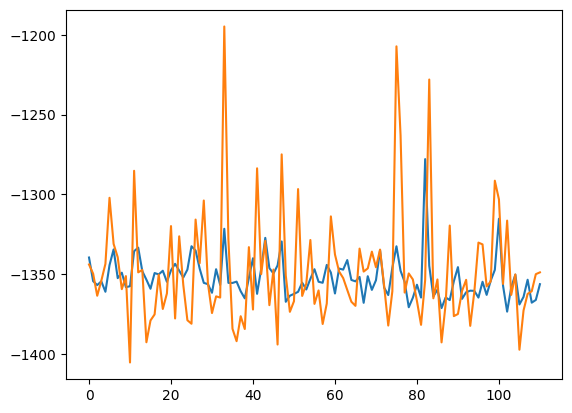

alpha 0.1 default_lr 0.0005


In [32]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [33]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [34]:
print(datetime.datetime.now())

2023-07-23 02:36:42.941689


# Iter 4

In [35]:
policy_evaluation_iter=3

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2
predict diverge [-8.79591671 -9.99675872 -0.14866571 -0.23528459] [-0.2463109  -0.38516944 -0.00491088 -0.11590502] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 143

 3

 4
predict diverge [ -8.43924412 -10.31204711  -0.39975595  -0.27626602] [-0.27994215 -0.42037971  0.00741311  0.11032196] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 182

 5

 6

 7

 8

 9

 10

 11
predict diverge [ -5.15874124 -10.43135761  -0.84732678  -2.11047119] [-0.26708912 -0.47305653 -0.07224636 -0.40676042] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 146

 12

 13

 14

 15

 16
predict diverge [ -2.59524871 -10.28963964  -0.69808167  -2.6992577 ] [-0.19795599 -0.38890951 -0.04276806 -0.72395255] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 74

 17

 18
predict diverge [-5.


 85

 86
predict diverge [ -4.0639774  -10.11378321  -0.19348139  -0.97557164] [-0.27745533 -0.42842661 -0.02230177 -0.02564352] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 79

 87
predict diverge [-4.83030577 -9.9880504  -0.32881657 -0.44859877] [-0.25261838 -0.43561562 -0.0067769  -0.33148504] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 81

 88

 89

 90

 91
predict diverge [ -4.73619515 -10.3962721   -0.58734374  -1.50195804] [-0.21703598 -0.43352247  0.01781351 -0.36638955] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 117

 92

 93
predict diverge [-10.30746396 -10.06609336  -0.1529924    0.25128251] [-0.25933594 -0.40341448  0.02706978 -0.07676835] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 178

 94

 95

 96
predict diverge [ -4.63099099 -10.3457642   -0

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.65536  validloss 0.81547±0.00000  bestvalidloss 0.81547  last_update 0
train: iter 1  trainloss 0.62390  validloss 0.75482±0.00000  bestvalidloss 0.75482  last_update 0
train: iter 2  trainloss 0.62042  validloss 0.74443±0.00000  bestvalidloss 0.74443  last_update 0
train: iter 3  trainloss 0.62795  validloss 0.72756±0.00000  bestvalidloss 0.72756  last_update 0
train: iter 4  trainloss 0.61764  validloss 0.74157±0.00000  bestvalidloss 0.72756  last_update 1
train: iter 5  trainloss 0.61224  validloss 0.73967±0.00000  bestvalidloss 0.72756  last_update 2
train: iter 6  trainloss 0.60974  validloss 0.73714±0.00000  bestvalidloss 0.72756  last_update 3
train: iter 7  trainloss 0.61029  validloss 0.75063±0.00000  bestvalidloss 0.72756  last_update 4
train: iter 8  trainloss 0.61116  validloss 0.74546±0.00000  bestvalidloss 0.72756  last_update 5
train: iter 9  trainloss 0.60366  validloss 0.74210±0.00000  bestvalidloss 0.72756  last_update 6
train: iter 10  trai

train: iter 83  trainloss 0.57299  validloss 0.74583±0.00000  bestvalidloss 0.72015  last_update 63
train: iter 84  trainloss 0.57433  validloss 0.75228±0.00000  bestvalidloss 0.72015  last_update 64
train: iter 85  trainloss 0.57171  validloss 0.74193±0.00000  bestvalidloss 0.72015  last_update 65
train: iter 86  trainloss 0.57243  validloss 0.73739±0.00000  bestvalidloss 0.72015  last_update 66
train: iter 87  trainloss 0.57191  validloss 0.72757±0.00000  bestvalidloss 0.72015  last_update 67
train: iter 88  trainloss 0.57996  validloss 0.74840±0.00000  bestvalidloss 0.72015  last_update 68
train: iter 89  trainloss 0.57002  validloss 0.73833±0.00000  bestvalidloss 0.72015  last_update 69
train: iter 90  trainloss 0.57532  validloss 0.73687±0.00000  bestvalidloss 0.72015  last_update 70
train: iter 91  trainloss 0.57252  validloss 0.72489±0.00000  bestvalidloss 0.72015  last_update 71
train: iter 92  trainloss 0.57028  validloss 0.73189±0.00000  bestvalidloss 0.72015  last_update 72


In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.388942229741813
valid_loss:  -7.327217514038085
weight_alpha 1.0 h_min_tilde -12.321483 ell_tilde -5.776597286601068 kappa_tilde 0.0003908849754644421
train_loss:  -6.5106090065002435
valid_loss:  -6.487645008850097
weight_alpha 0.1 h_min_tilde -12.321483 ell_tilde -6.506016206970214 kappa_tilde 0.00041467487522880736


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1281.87931  validloss -1301.35798±0.00000  bestvalidloss -1301.35798  last_update 0
train: iter 1  trainloss -1276.97368  validloss -1241.18712±0.00000  bestvalidloss -1301.35798  last_update 1
train: iter 2  trainloss -1300.70503  validloss -1301.34081±0.00000  bestvalidloss -1301.35798  last_update 2
train: iter 3  trainloss -1304.28367  validloss -1280.58907±0.00000  bestvalidloss -1301.35798  last_update 3
train: iter 4  trainloss -1297.43708  validloss -1307.49700±0.00000  bestvalidloss -1307.49700  last_update 0
train: iter 5  trainloss -1302.31319  validloss -1303.15912±0.00000  bestvalidloss -1307.49700  last_update 1
train: iter 6  trainloss -1294.15951  validloss -1306.79753±0.00000  bestvalidloss -1307.49700  last_update 2
train: iter 7  trainloss -1291.39871  validloss -1230.30440±0.00000  bestvalidloss -1307.49700  last_update 3
train: iter 8  trainloss -1266.46469  validloss -1297.69104±0.00000  bestva

train: iter 74  trainloss -1290.41283  validloss -1226.60996±0.00000  bestvalidloss -1336.85017  last_update 32
train: iter 75  trainloss -1306.48488  validloss -1298.64695±0.00000  bestvalidloss -1336.85017  last_update 33
train: iter 76  trainloss -1294.09571  validloss -1301.22125±0.00000  bestvalidloss -1336.85017  last_update 34
train: iter 77  trainloss -1306.22836  validloss -1275.43892±0.00000  bestvalidloss -1336.85017  last_update 35
train: iter 78  trainloss -1313.06110  validloss -1274.10765±0.00000  bestvalidloss -1336.85017  last_update 36
train: iter 79  trainloss -1311.60769  validloss -1265.17809±0.00000  bestvalidloss -1336.85017  last_update 37
train: iter 80  trainloss -1305.90804  validloss -1278.46334±0.00000  bestvalidloss -1336.85017  last_update 38
train: iter 81  trainloss -1293.66624  validloss -1263.40125±0.00000  bestvalidloss -1336.85017  last_update 39
train: iter 82  trainloss -1303.00184  validloss -1308.50902±0.00000  bestvalidloss -1336.85017  last_up

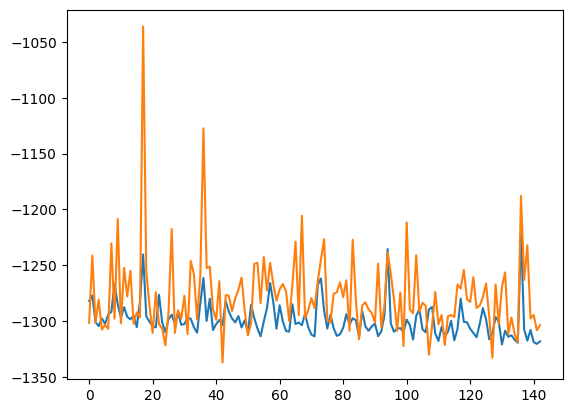

alpha 0.1 default_lr 0.0005


In [40]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [41]:
print(datetime.datetime.now())

2023-07-23 02:57:14.615099


# Iter 5

In [42]:
policy_evaluation_iter=4

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5
predict diverge [ -5.80124282 -10.35793473  -0.3651322   -0.58716062] [-0.2448264  -0.4779462  -0.01804913 -0.18671342] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 80

 6

 7
predict diverge [-7.06620025e+00 -1.00191465e+01 -2.76865332e-01  4.48678750e-03] [-0.26333912 -0.41078803 -0.0185381   0.03864866] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 127
predict diverge [ -3.94205303 -10.27328551  -0.3010541   -1.77416909] [-0.22203569 -0.45898179 -0.03256023 -0.2906184 ] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 99

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19
predict diverge [ -3.78470831 -10.04049052  -0.65870557  -2.84449844] [-0.22707366 -0.45146183 -0.0761886  -0.27589659] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 101


In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.67614  validloss 0.80399±0.00000  bestvalidloss 0.80399  last_update 0
train: iter 1  trainloss 0.65770  validloss 0.76120±0.00000  bestvalidloss 0.76120  last_update 0
train: iter 2  trainloss 0.65239  validloss 0.73493±0.00000  bestvalidloss 0.73493  last_update 0
train: iter 3  trainloss 0.65477  validloss 0.76362±0.00000  bestvalidloss 0.73493  last_update 1
train: iter 4  trainloss 0.65307  validloss 0.74410±0.00000  bestvalidloss 0.73493  last_update 2
train: iter 5  trainloss 0.64645  validloss 0.74313±0.00000  bestvalidloss 0.73493  last_update 3
train: iter 6  trainloss 0.64115  validloss 0.77524±0.00000  bestvalidloss 0.73493  last_update 4
train: iter 7  trainloss 0.64726  validloss 0.74209±0.00000  bestvalidloss 0.73493  last_update 5
train: iter 8  trainloss 0.64070  validloss 0.75017±0.00000  bestvalidloss 0.73493  last_update 6
train: iter 9  trainloss 0.63499  validloss 0.74271±0.00000  bestvalidloss 0.73493  last_update 7
train: iter 10  trai

train: iter 84  trainloss 0.61137  validloss 0.74632±0.00000  bestvalidloss 0.72831  last_update 52
train: iter 85  trainloss 0.60770  validloss 0.74687±0.00000  bestvalidloss 0.72831  last_update 53
train: iter 86  trainloss 0.61218  validloss 0.74712±0.00000  bestvalidloss 0.72831  last_update 54
train: iter 87  trainloss 0.61148  validloss 0.78041±0.00000  bestvalidloss 0.72831  last_update 55
train: iter 88  trainloss 0.60954  validloss 0.77707±0.00000  bestvalidloss 0.72831  last_update 56
train: iter 89  trainloss 0.60888  validloss 0.74031±0.00000  bestvalidloss 0.72831  last_update 57
train: iter 90  trainloss 0.61396  validloss 0.73475±0.00000  bestvalidloss 0.72831  last_update 58
train: iter 91  trainloss 0.60430  validloss 0.75863±0.00000  bestvalidloss 0.72831  last_update 59
train: iter 92  trainloss 0.60598  validloss 0.75217±0.00000  bestvalidloss 0.72831  last_update 60
train: iter 93  trainloss 0.60963  validloss 0.75923±0.00000  bestvalidloss 0.72831  last_update 61


In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -9.488251163482667
valid_loss:  -11.841503051757815
weight_alpha 1.0 h_min_tilde -12.323858 ell_tilde -9.958901541137697 kappa_tilde 0.000650262038759998
train_loss:  -7.580025482177734
valid_loss:  -7.470133930969238
weight_alpha 0.1 h_min_tilde -12.323858 ell_tilde -7.558047171936035 kappa_tilde 0.0004580697241347692


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1509.18864  validloss -1494.28213±0.00000  bestvalidloss -1494.28213  last_update 0
train: iter 1  trainloss -1507.76533  validloss -1509.69308±0.00000  bestvalidloss -1509.69308  last_update 0
train: iter 2  trainloss -1508.69997  validloss -1480.16416±0.00000  bestvalidloss -1509.69308  last_update 1
train: iter 3  trainloss -1504.60360  validloss -1530.45495±0.00000  bestvalidloss -1530.45495  last_update 0
train: iter 4  trainloss -1468.43174  validloss -1497.70068±0.00000  bestvalidloss -1530.45495  last_update 1
train: iter 5  trainloss -1490.86924  validloss -1424.68701±0.00000  bestvalidloss -1530.45495  last_update 2
train: iter 6  trainloss -1493.19022  validloss -1504.25748±0.00000  bestvalidloss -1530.45495  last_update 3
train: iter 7  trainloss -1503.31281  validloss -1525.77832±0.00000  bestvalidloss -1530.45495  last_update 4
train: iter 8  trainloss -1496.35246  validloss -1552.90185±0.00000  bestva

train: iter 74  trainloss -1520.54754  validloss -1506.15262±0.00000  bestvalidloss -1556.47526  last_update 16
train: iter 75  trainloss -1499.68650  validloss -1541.92626±0.00000  bestvalidloss -1556.47526  last_update 17
train: iter 76  trainloss -1492.86277  validloss -1448.00234±0.00000  bestvalidloss -1556.47526  last_update 18
train: iter 77  trainloss -1520.12760  validloss -1497.82259±0.00000  bestvalidloss -1556.47526  last_update 19
train: iter 78  trainloss -1517.12510  validloss -1481.64893±0.00000  bestvalidloss -1556.47526  last_update 20
train: iter 79  trainloss -1514.16991  validloss -1456.41855±0.00000  bestvalidloss -1556.47526  last_update 21
train: iter 80  trainloss -1520.02558  validloss -1507.27438±0.00000  bestvalidloss -1556.47526  last_update 22
train: iter 81  trainloss -1519.91397  validloss -1512.97919±0.00000  bestvalidloss -1556.47526  last_update 23
train: iter 82  trainloss -1517.38244  validloss -1544.17820±0.00000  bestvalidloss -1556.47526  last_up

train: iter 147  trainloss -1509.16367  validloss -1533.63330±0.00000  bestvalidloss -1575.44228  last_update 20
train: iter 148  trainloss -1525.30473  validloss -1501.37761±0.00000  bestvalidloss -1575.44228  last_update 21
train: iter 149  trainloss -1522.85730  validloss -1551.82030±0.00000  bestvalidloss -1575.44228  last_update 22
train: iter 150  trainloss -1525.54585  validloss -1552.52825±0.00000  bestvalidloss -1575.44228  last_update 23
train: iter 151  trainloss -1497.60840  validloss -1497.53878±0.00000  bestvalidloss -1575.44228  last_update 24
train: iter 152  trainloss -1528.52071  validloss -1504.52954±0.00000  bestvalidloss -1575.44228  last_update 25
train: iter 153  trainloss -1530.89840  validloss -1523.29044±0.00000  bestvalidloss -1575.44228  last_update 26
train: iter 154  trainloss -1513.72788  validloss -1556.41571±0.00000  bestvalidloss -1575.44228  last_update 27
train: iter 155  trainloss -1528.72024  validloss -1536.55793±0.00000  bestvalidloss -1575.44228

train: iter 220  trainloss -1532.11416  validloss -1493.59193±0.00000  bestvalidloss -1575.44228  last_update 93
train: iter 221  trainloss -1525.73653  validloss -1493.70826±0.00000  bestvalidloss -1575.44228  last_update 94
train: iter 222  trainloss -1531.10664  validloss -1531.85893±0.00000  bestvalidloss -1575.44228  last_update 95
train: iter 223  trainloss -1539.44423  validloss -1532.75545±0.00000  bestvalidloss -1575.44228  last_update 96
train: iter 224  trainloss -1529.88876  validloss -1541.26706±0.00000  bestvalidloss -1575.44228  last_update 97
train: iter 225  trainloss -1533.49873  validloss -1513.35863±0.00000  bestvalidloss -1575.44228  last_update 98
train: iter 226  trainloss -1532.56659  validloss -1536.01786±0.00000  bestvalidloss -1575.44228  last_update 99
train: iter 227  trainloss -1530.68932  validloss -1534.55076±0.00000  bestvalidloss -1575.44228  last_update 100
train: fin
penalty_target_min tensor(-12.3112) penalty_target_max tensor(9.4714)


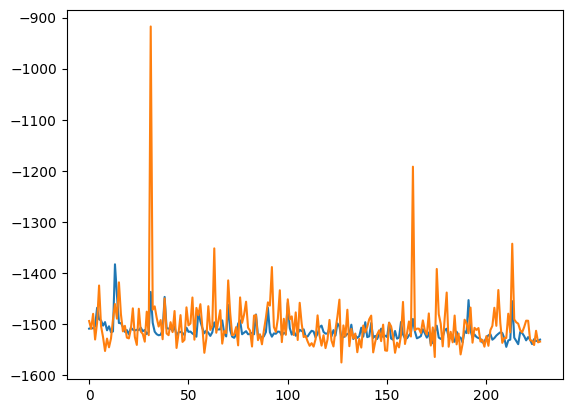

alpha 0.1 default_lr 0.0005


In [47]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [48]:
print(datetime.datetime.now())

2023-07-23 03:16:59.115465


# 評価関数計算

In [49]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36
predict diverge [ -4.53222347 -10.32011523  -0.67412479  -0.52094059] [-0.24170247 -0.36996238 -0.01317451 -0.07795762] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 113

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75
predict diverge [-4.72887138 -9.99829362 -0.12982302  0.69118133] [-0.23476016 -0.41170598 -0.00376512  0.26464835] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 195

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [50]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.65758  validloss 0.83997±0.00000  bestvalidloss 0.83997  last_update 0
train: iter 1  trainloss 0.63799  validloss 0.75873±0.00000  bestvalidloss 0.75873  last_update 0
train: iter 2  trainloss 0.62322  validloss 0.75447±0.00000  bestvalidloss 0.75447  last_update 0
train: iter 3  trainloss 0.62522  validloss 0.74045±0.00000  bestvalidloss 0.74045  last_update 0
train: iter 4  trainloss 0.61802  validloss 0.74579±0.00000  bestvalidloss 0.74045  last_update 1
train: iter 5  trainloss 0.61908  validloss 0.74303±0.00000  bestvalidloss 0.74045  last_update 2
train: iter 6  trainloss 0.61350  validloss 0.77418±0.00000  bestvalidloss 0.74045  last_update 3
train: iter 7  trainloss 0.61573  validloss 0.74270±0.00000  bestvalidloss 0.74045  last_update 4
train: iter 8  trainloss 0.61311  validloss 0.73664±0.00000  bestvalidloss 0.73664  last_update 0
train: iter 9  trainloss 0.60675  validloss 0.74175±0.00000  bestvalidloss 0.73664  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.58380  validloss 0.71335±0.00000  bestvalidloss 0.69023  last_update 35
train: iter 84  trainloss 0.58670  validloss 0.72498±0.00000  bestvalidloss 0.69023  last_update 36
train: iter 85  trainloss 0.59227  validloss 0.73412±0.00000  bestvalidloss 0.69023  last_update 37
train: iter 86  trainloss 0.58356  validloss 0.69335±0.00000  bestvalidloss 0.69023  last_update 38
train: iter 87  trainloss 0.58501  validloss 0.69851±0.00000  bestvalidloss 0.69023  last_update 39
train: iter 88  trainloss 0.58590  validloss 0.69419±0.00000  bestvalidloss 0.69023  last_update 40
train: iter 89  trainloss 0.58898  validloss 0.68808±0.00000  bestvalidloss 0.68808  last_update 0
train: iter 90  trainloss 0.58900  validloss 0.70984±0.00000  bestvalidloss 0.68808  last_update 1
train: iter 91  trainloss 0.58490  validloss 0.70580±0.00000  bestvalidloss 0.68808  last_update 2
train: iter 92  trainloss 0.58579  validloss 0.69287±0.00000  bestvalidloss 0.68808  last_update 3
trai

train: iter 166  trainloss 0.56798  validloss 0.70068±0.00000  bestvalidloss 0.68319  last_update 24
train: iter 167  trainloss 0.56896  validloss 0.69049±0.00000  bestvalidloss 0.68319  last_update 25
train: iter 168  trainloss 0.57498  validloss 0.71761±0.00000  bestvalidloss 0.68319  last_update 26
train: iter 169  trainloss 0.56927  validloss 0.69367±0.00000  bestvalidloss 0.68319  last_update 27
train: iter 170  trainloss 0.57501  validloss 0.70432±0.00000  bestvalidloss 0.68319  last_update 28
train: iter 171  trainloss 0.56617  validloss 0.70634±0.00000  bestvalidloss 0.68319  last_update 29
train: iter 172  trainloss 0.56865  validloss 0.70519±0.00000  bestvalidloss 0.68319  last_update 30
train: iter 173  trainloss 0.56715  validloss 0.71677±0.00000  bestvalidloss 0.68319  last_update 31
train: iter 174  trainloss 0.56721  validloss 0.72548±0.00000  bestvalidloss 0.68319  last_update 32
train: iter 175  trainloss 0.57271  validloss 0.68292±0.00000  bestvalidloss 0.68292  last_

train: iter 248  trainloss 0.55641  validloss 0.69325±0.00000  bestvalidloss 0.67989  last_update 64
train: iter 249  trainloss 0.55575  validloss 0.70611±0.00000  bestvalidloss 0.67989  last_update 65
train: iter 250  trainloss 0.56163  validloss 0.71381±0.00000  bestvalidloss 0.67989  last_update 66
train: iter 251  trainloss 0.55469  validloss 0.69858±0.00000  bestvalidloss 0.67989  last_update 67
train: iter 252  trainloss 0.55821  validloss 0.72010±0.00000  bestvalidloss 0.67989  last_update 68
train: iter 253  trainloss 0.55684  validloss 0.71168±0.00000  bestvalidloss 0.67989  last_update 69
train: iter 254  trainloss 0.55020  validloss 0.71271±0.00000  bestvalidloss 0.67989  last_update 70
train: iter 255  trainloss 0.55494  validloss 0.74003±0.00000  bestvalidloss 0.67989  last_update 71
train: iter 256  trainloss 0.55887  validloss 0.70651±0.00000  bestvalidloss 0.67989  last_update 72
train: iter 257  trainloss 0.55155  validloss 0.71411±0.00000  bestvalidloss 0.67989  last_

([0.6575844205915928,
  0.6379867557436227,
  0.623219302855432,
  0.6252228651195765,
  0.618024741485715,
  0.6190756000578403,
  0.6134973905980587,
  0.6157254263758659,
  0.6131136275827884,
  0.6067502222955227,
  0.6093617971986532,
  0.6100664867088199,
  0.6076759403571487,
  0.6111705653369427,
  0.6083105860278011,
  0.6154263185337185,
  0.6103103365749121,
  0.6048887092620134,
  0.6083500318229198,
  0.603339989669621,
  0.6037320345640182,
  0.6058669127523899,
  0.602705417945981,
  0.6101141836494207,
  0.6032698232680559,
  0.600851277448237,
  0.5969365298748016,
  0.6023126870393753,
  0.6030622934922576,
  0.6025588802993298,
  0.5999006798490882,
  0.5983130859211088,
  0.6049802226945757,
  0.6003382090479136,
  0.5959274217486381,
  0.5960359681397677,
  0.5966456050053239,
  0.6030981216579676,
  0.6002986678853631,
  0.5945813540369272,
  0.5997617421671748,
  0.5990732545033097,
  0.596313806436956,
  0.5949467847123742,
  0.5928928092122078,
  0.596662963367

In [51]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.361283651834726
valid_loss:  -9.577217161369322
weight_alpha 1.0 h_min_tilde -12.311207 ell_tilde -7.004470353741644 kappa_tilde 0.0004340964553599269
train_loss:  -7.004093291282655
valid_loss:  -7.132506535339355
weight_alpha 0.1 h_min_tilde -12.311207 ell_tilde -7.0297759400939945 kappa_tilde 0.00043513518316762306


In [52]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 19.09123  validloss 16.68499±0.00000  bestvalidloss 16.68499  last_update 0
train: iter 1  trainloss 15.71793  validloss 12.85625±0.00000  bestvalidloss 12.85625  last_update 0
train: iter 2  trainloss 13.15203  validloss 10.28734±0.00000  bestvalidloss 10.28734  last_update 0
train: iter 3  trainloss 11.13868  validloss 8.29295±0.00000  bestvalidloss 8.29295  last_update 0
train: iter 4  trainloss 9.48475  validloss 6.77416±0.00000  bestvalidloss 6.77416  last_update 0
train: iter 5  trainloss 8.18340  validloss 5.50881±0.00000  bestvalidloss 5.50881  last_update 0
train: iter 6  trainloss 7.12387  validloss 4.55499±0.00000  bestvalidloss 4.55499  last_update 0
train: iter 7  trainloss 6.09553  validloss 3.56801±0.00000  bestvalidloss 3.56801  last_update 0
train: iter 8  trainloss 5.34032  validloss 3.05238±0.00000  bestvalidloss 3.05238  last_update 0
train: iter 9  trainloss 4.70286  validloss 2.45516±0.00000  bestvalidloss 2.45516  last_update 0
train: ite

train: iter 86  trainloss 0.89268  validloss 0.34938±0.00000  bestvalidloss 0.14105  last_update 57
train: iter 87  trainloss 0.86500  validloss 0.34190±0.00000  bestvalidloss 0.14105  last_update 58
train: iter 88  trainloss 0.89290  validloss 0.32334±0.00000  bestvalidloss 0.14105  last_update 59
train: iter 89  trainloss 0.88104  validloss 0.35253±0.00000  bestvalidloss 0.14105  last_update 60
train: iter 90  trainloss 0.87398  validloss 0.37252±0.00000  bestvalidloss 0.14105  last_update 61
train: iter 91  trainloss 0.87274  validloss 0.33657±0.00000  bestvalidloss 0.14105  last_update 62
train: iter 92  trainloss 0.86985  validloss 0.34864±0.00000  bestvalidloss 0.14105  last_update 63
train: iter 93  trainloss 0.86246  validloss 0.37123±0.00000  bestvalidloss 0.14105  last_update 64
train: iter 94  trainloss 0.87631  validloss 0.32724±0.00000  bestvalidloss 0.14105  last_update 65
train: iter 95  trainloss 0.86645  validloss 0.34162±0.00000  bestvalidloss 0.14105  last_update 66


In [53]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-1.4896, -1.5406, -2.6128, -2.7705], requires_grad=True)


In [54]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 3.21868  validloss 8.88829±0.00000  bestvalidloss 8.88829  last_update 0
train: iter 1  trainloss 2.51674  validloss 7.34496±0.00000  bestvalidloss 7.34496  last_update 0
train: iter 2  trainloss 2.46697  validloss 7.40540±0.00000  bestvalidloss 7.34496  last_update 1
train: iter 3  trainloss 2.44738  validloss 7.27951±0.00000  bestvalidloss 7.27951  last_update 0
train: iter 4  trainloss 2.40481  validloss 6.91579±0.00000  bestvalidloss 6.91579  last_update 0
train: iter 5  trainloss 2.39939  validloss 6.69168±0.00000  bestvalidloss 6.69168  last_update 0
train: iter 6  trainloss 2.38201  validloss 6.94976±0.00000  bestvalidloss 6.69168  last_update 1
train: iter 7  trainloss 2.36845  validloss 6.52333±0.00000  bestvalidloss 6.52333  last_update 0
train: iter 8  trainloss 2.36919  validloss 6.67487±0.00000  bestvalidloss 6.52333  last_update 1
train: iter 9  trainloss 2.35896  validloss 6.69867±0.00000  bestvalidloss 6.52333  last_update 2
train: iter 10  trai

train: iter 84  trainloss 2.32034  validloss 6.29493±0.00000  bestvalidloss 5.96094  last_update 41
train: iter 85  trainloss 2.29573  validloss 6.42792±0.00000  bestvalidloss 5.96094  last_update 42
train: iter 86  trainloss 2.37526  validloss 6.61453±0.00000  bestvalidloss 5.96094  last_update 43
train: iter 87  trainloss 2.29495  validloss 6.68424±0.00000  bestvalidloss 5.96094  last_update 44
train: iter 88  trainloss 2.31152  validloss 6.51692±0.00000  bestvalidloss 5.96094  last_update 45
train: iter 89  trainloss 2.29793  validloss 6.17327±0.00000  bestvalidloss 5.96094  last_update 46
train: iter 90  trainloss 2.27315  validloss 6.74069±0.00000  bestvalidloss 5.96094  last_update 47
train: iter 91  trainloss 2.33890  validloss 6.81197±0.00000  bestvalidloss 5.96094  last_update 48
train: iter 92  trainloss 2.35111  validloss 6.42426±0.00000  bestvalidloss 5.96094  last_update 49
train: iter 93  trainloss 2.33155  validloss 6.55487±0.00000  bestvalidloss 5.96094  last_update 50


In [55]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-8.4134)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(14.2850)


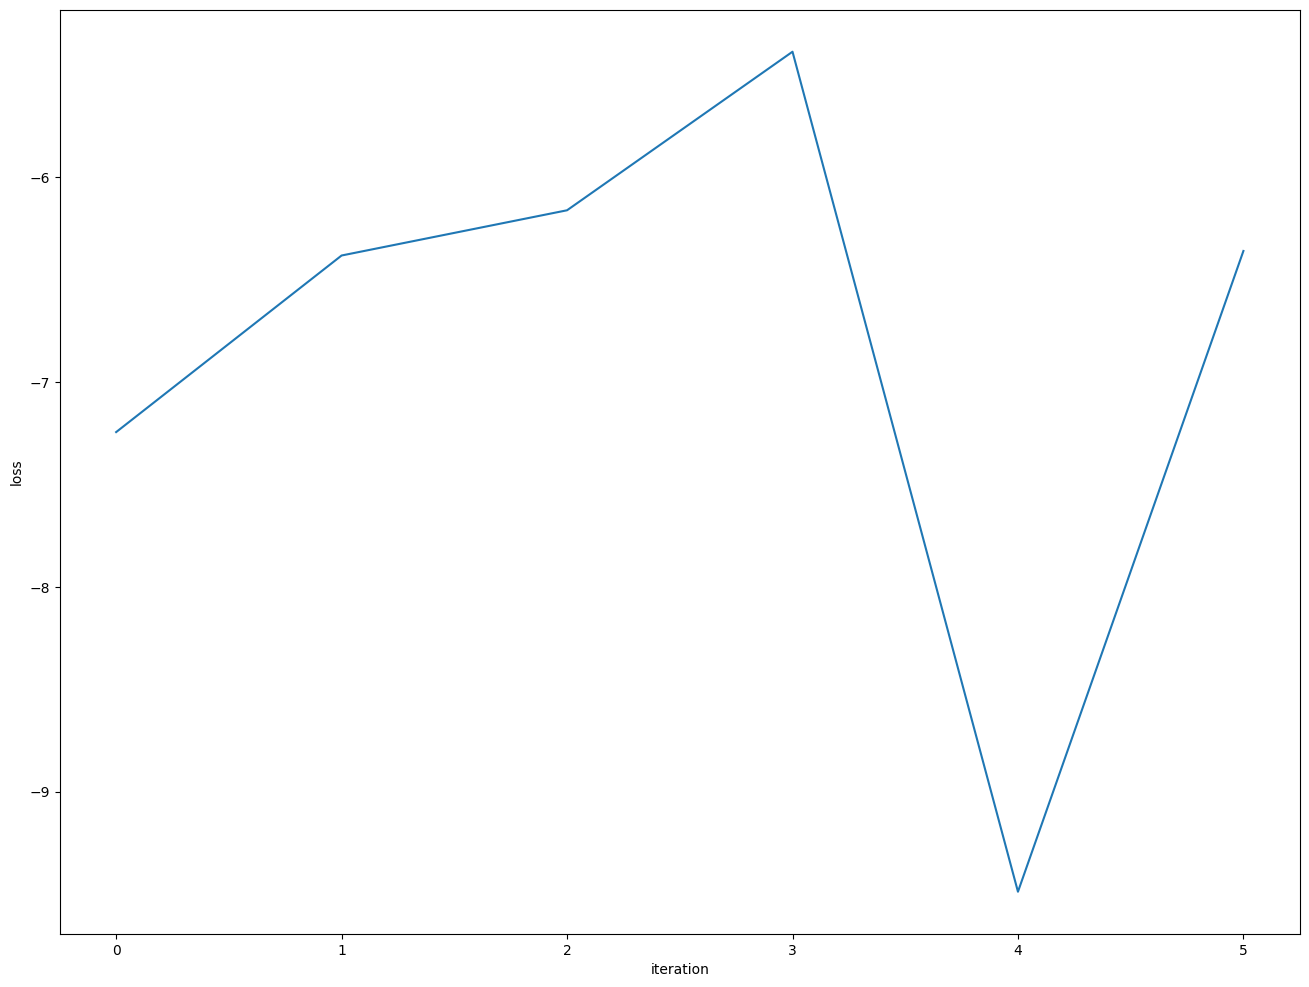

In [56]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

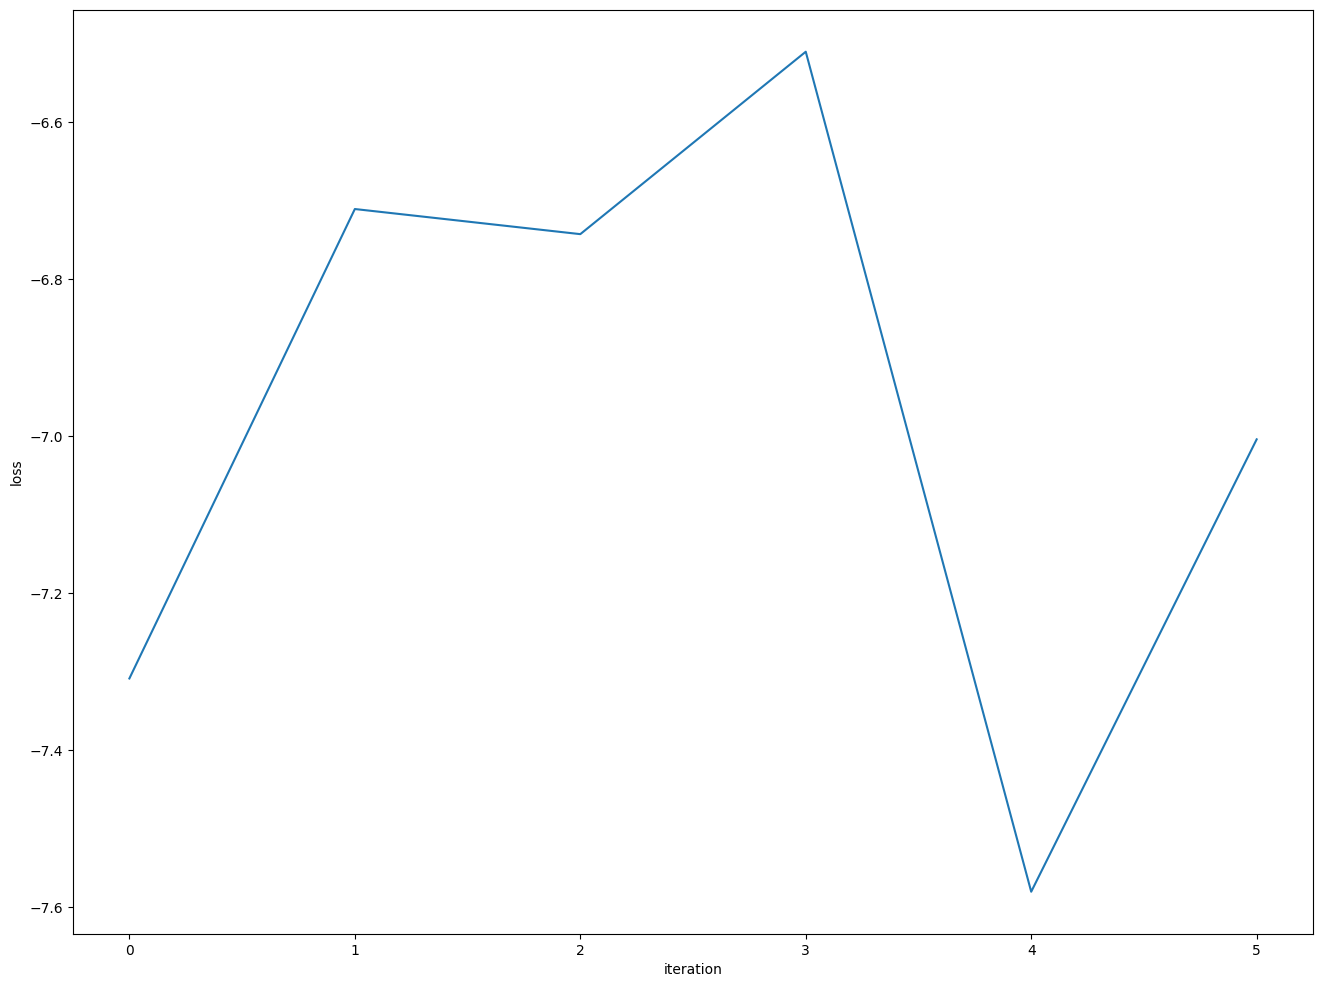

In [57]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")